In [56]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, BoundaryNorm
import nibabel as nib
from nilearn import plotting, datasets, image
from scipy.stats import skew, kurtosis, norm
from scipy import ndimage
import pandas as pd

In [23]:
results = np.load('/Users/zkavian/Downloads/GLMOutputs2-sub04-ses01/TYPED_FITHRF_GLMDENOISE_RR.npy', allow_pickle=True).item()
print(results.keys())

dict_keys(['HRFindex', 'HRFindexrun', 'glmbadness', 'pcvoxels', 'pcnum', 'xvaltrend', 'noisepool', 'pcregressors', 'betasmd', 'R2', 'R2run', 'rrbadness', 'FRACvalue', 'scaleoffset', 'meanvol'])


In [34]:
betasmd = results['betasmd'][:,:,:,0:90]

X, Y, Z, T = betasmd.shape
V = X * Y * Z
print(f"Number of total voxels {V}")
B = betasmd.reshape(V, T)

n = np.sum(~np.isnan(B), axis=1) # number of valid (non-NaN) trials for each voxel

mu = np.nanmean(B, axis=1) # mean beta across valid trials for each voxel
sd = np.nanstd(B, axis=1, ddof=1) # std dev of beta across valid trials for each voxel
se = sd / np.sqrt(np.clip(n, 1, None)); t = mu / se  #t-stat

mu_vol = mu.reshape(X, Y, Z)
sd_vol = sd.reshape(X, Y, Z)
n_vol  = n.reshape(X, Y, Z)
t_vol  = t.reshape(X, Y, Z)

R2 = results['R2run'][:,:,:,0]

t_thr = 3
R2_thr = 1.5

base = (R2 > R2_thr) & (np.abs(t_vol) > t_thr)
print(f"Number of Active voxels {np.sum(base)}")

mask_pos = base & (mu_vol > 0)
print(f"Number of Positively Active voxels {np.sum(mask_pos)}")
mask_neg = base & (mu_vol < 0)
print(f"Number of Negatively Active voxels {np.sum(mask_neg)}")

Number of total voxels 979200


/var/folders/q6/qg04k8n96gd2f76yth1svqch0000gs/T/ipykernel_3372/3375456871.py:10: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(B, axis=1) # mean beta across valid trials for each voxel


Number of Active voxels 87656
Number of Positively Active voxels 56926
Number of Negatively Active voxels 30730


/Users/zkavian/Desktop/Workspace/Python_code/GLMSingle/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/q6/qg04k8n96gd2f76yth1svqch0000gs/T/ipykernel_3372/3375456871.py:12: RuntimeWarning: divide by zero encountered in divide
  se = sd / np.sqrt(np.clip(n, 1, None)); t = mu / se  #t-stat
/var/folders/q6/qg04k8n96gd2f76yth1svqch0000gs/T/ipykernel_3372/3375456871.py:12: RuntimeWarning: invalid value encountered in divide
  se = sd / np.sqrt(np.clip(n, 1, None)); t = mu / se  #t-stat


In [41]:
betasmd = results['betasmd']
mask_union = mask_pos | mask_neg
beta_pos = betasmd[mask_union,:]
# print(beta_pos.shape) #(87656, 180)

beta_pos1 = beta_pos[:,:90]
beta_pos2 = beta_pos[:,90:]

beta_diff1 = np.diff(beta_pos1, axis=1)
beta_diff2 = np.diff(beta_pos2, axis=1)

sk1 = skew(beta_diff1, axis=1, bias=False)
kt1 = kurtosis(beta_diff1, axis=1, fisher=False, bias=False)
sk2 = skew(beta_diff2, axis=1, bias=False)
kt2 = kurtosis(beta_diff2, axis=1, fisher=False, bias=False)

sk_thr = 0.1                        # |sk| < 0.1 → near-symmetric
kt_thr = 0.2                        # |kt-3| < 0.2 → near-Normal kurtosis

# voxels meeting both criteria
mask_gaussian_like = (np.abs(sk1) < sk_thr) & (np.abs(kt1 - 3) < kt_thr)
selected_voxels_run1 = np.zeros(mask_pos.shape, dtype=bool)
selected_voxels_run1[mask_union] = mask_gaussian_like
print(selected_voxels_run1.shape)

mask_gaussian_like = (np.abs(sk2) < sk_thr) & (np.abs(kt2 - 3) < kt_thr)
selected_voxels_run2 = np.zeros(mask_pos.shape, dtype=bool)
selected_voxels_run2[mask_union] = mask_gaussian_like
print(selected_voxels_run2.shape)

(90, 128, 85)
(90, 128, 85)


/Users/zkavian/Desktop/Workspace/Python_code/GLMSingle/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1361: RuntimeWarning: invalid value encountered in divide
  nval = ((n - 1.0) * n)**0.5 / (n - 2.0) * m3 / m2**1.5
/Users/zkavian/Desktop/Workspace/Python_code/GLMSingle/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1469: RuntimeWarning: invalid value encountered in divide
  nval = 1.0/(n-2)/(n-3) * ((n**2-1.0)*m4/m2**2.0 - 3*(n-1)**2.0)


In [45]:
def plot_active_voxels_sech(vol, ses, run):
    fig, axes = plt.subplots(1, 3, figsize=(8, 8))
    ax_sag, ax_cor, ax_axial = axes
    fig.suptitle(f"Less Variable Voxles-session {ses}-Run {run}")

    x = vol.shape[0] // 2
    y = vol.shape[1] // 2
    z = vol.shape[2] // 2

    im_sag = ax_sag.imshow(np.rot90(vol[x, :, :]), cmap="gray", origin='lower')
    ax_sag.set_title("Sagittal")
    ax_sag.axis("off")


    im_cor = ax_cor.imshow(np.rot90(vol[:, y, :]), cmap="gray", origin='lower')
    ax_cor.set_title("Coronal")        
    ax_cor.axis("off")

    im_ax = ax_axial.imshow(np.rot90(vol[:, :, z]), cmap="gray", origin='lower')
    ax_axial.set_title("Axial")   
    ax_axial.axis("off")


    def update(i):
        im_sag.set_data(np.rot90(vol[i, :, :]))      # sagittal slices
        im_cor.set_data(np.rot90(vol[:, i, :]))      # coronal slices
        im_ax.set_data(np.rot90(vol[:, :, i]))       # axial slices
        return im_sag, im_cor, im_ax

    ani = FuncAnimation(fig, update, frames=range(min(vol.shape)), interval=100, blit=False)
    fig.tight_layout(rect=[0, 0, 1, 1.5])
    plt.show()

    ani.save(filename=f"selected_voxels_session{ses}_run{run}.gif", writer="pillow")
    return

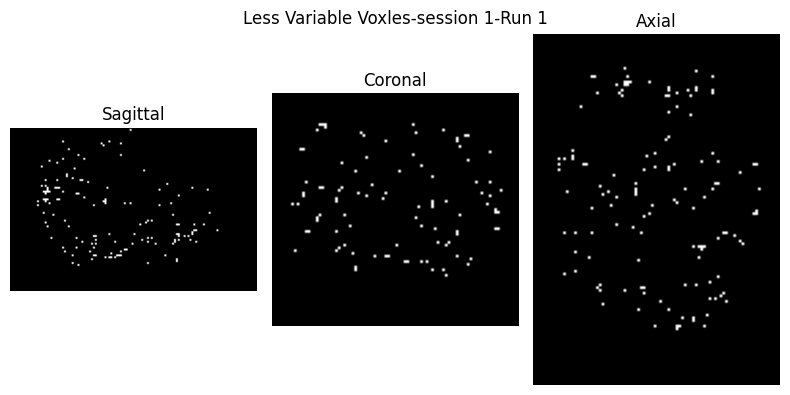

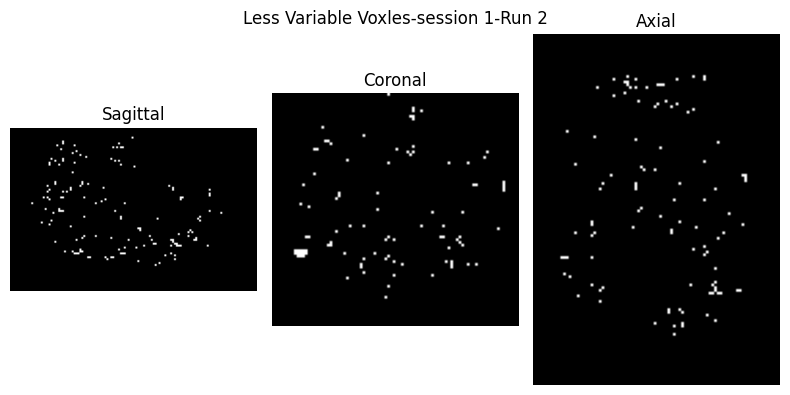

In [46]:
ses = 1
run = 1
plot_active_voxels_sech(selected_voxels_run1, ses, run)

run = 2
plot_active_voxels_sech(selected_voxels_run2, ses, run)

In [48]:
def plot_dist(beta_diff):
    mu    = beta_diff.mean(axis=1)
    sigma = beta_diff.std(axis=1, ddof=1)          # sample std
    sk    = skew(beta_diff, axis=1, bias=False)
    kt    = kurtosis(beta_diff, axis=1, fisher=False, bias=False)

    # Plot a few example rows
    rows_to_show = np.random.choice(beta_diff.shape[0], 5, replace=False)

    fig, axes = plt.subplots(len(rows_to_show), 1, figsize=(6, 2.5*len(rows_to_show)))

    for ax, idx in zip(axes, rows_to_show):
        data = beta_diff[idx]
        m, s = mu[idx], sigma[idx]
        x = np.linspace(data.min(), data.max(), 200)

        ax.hist(data, bins=25, density=True, alpha=0.5, label='data')
        ax.plot(x, norm.pdf(x, m, s), 'r', lw=2, label='Gaussian fit')
        ax.set_title(f'Row {idx}: μ={m:.2f}, σ={s:.2f}, skew={sk[idx]:.2f}, kurt={kt[idx]:.2f}')
        ax.legend()

    plt.tight_layout()
    plt.show()

    return

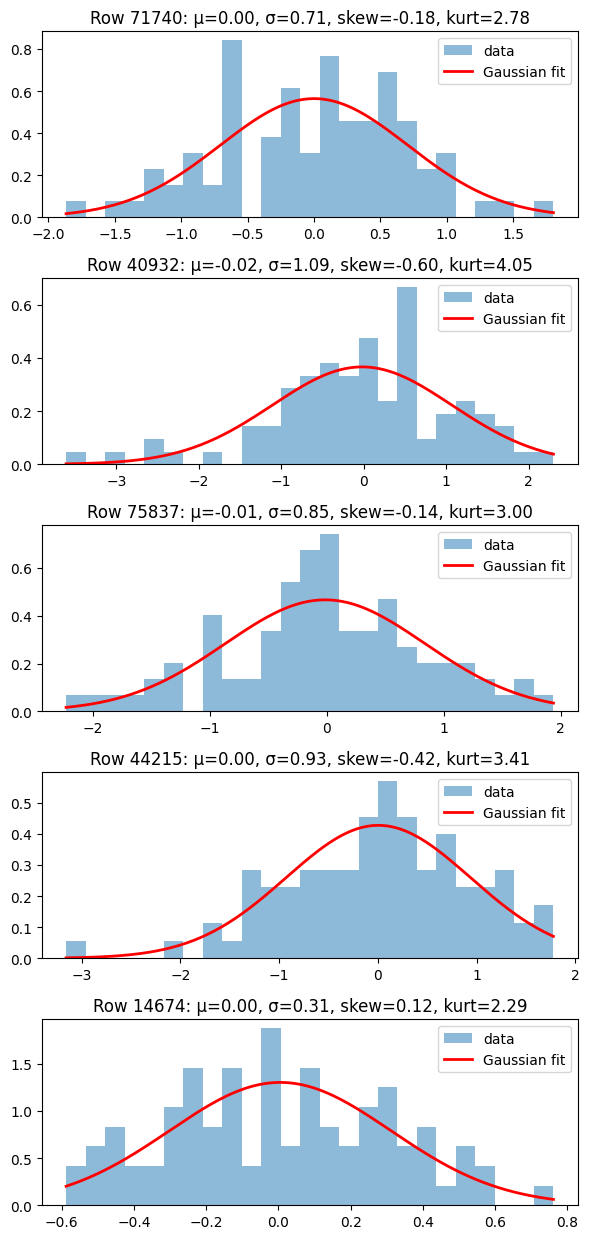

In [50]:
plot_dist(beta_diff1)

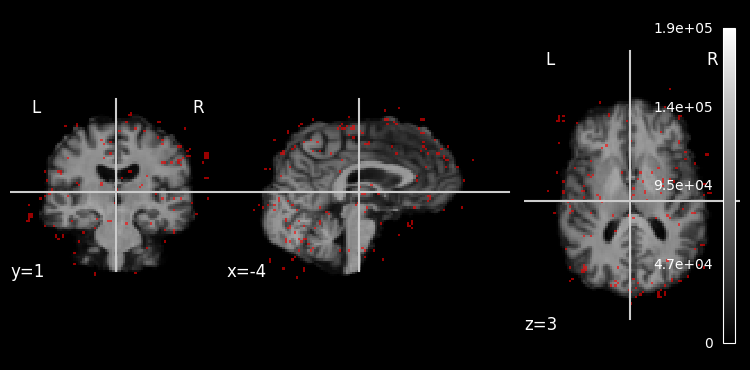

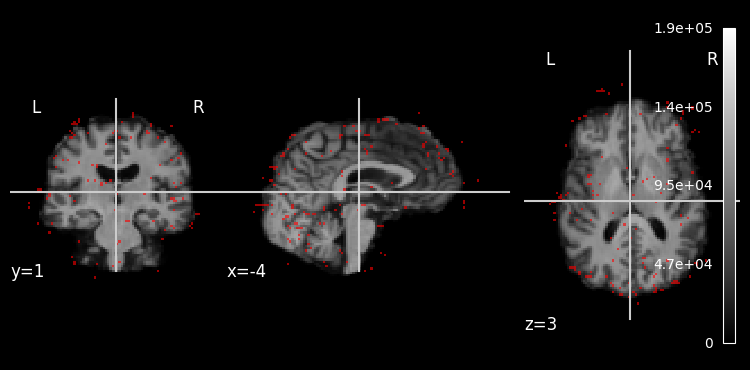

In [53]:
anat_img = nib.load('/Volumes/McKeownLab/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd004/ses-1/anat/sub-pd004_ses-1_T1w_brain_2mm.nii.gz')
anat_data = anat_img.get_fdata()
affine = anat_img.affine
ses = 1
run = 1

selected_img = nib.Nifti1Image(selected_voxels_run1.astype(np.uint8), affine)
nib.save(selected_img, f'selected_voxels_session{ses}_run{run}.nii.gz')
display = plotting.plot_anat(anat_img, display_mode="ortho")
display.add_overlay(selected_img, cmap="autumn", transparency=0.6, threshold=0.5)
plotting.show()

run = 2
selected_img = nib.Nifti1Image(selected_voxels_run2.astype(np.uint8), affine)
nib.save(selected_img, f'selected_voxels_session{ses}_run{run}.nii.gz')
display = plotting.plot_anat(anat_img, display_mode="ortho")
display.add_overlay(selected_img, cmap="autumn", transparency=0.6, threshold=0.5)
plotting.show()

In [57]:
def determine_rois(data_path, ses, run):
    stat_img = nib.load(data_path)
    stat = stat_img.get_fdata()
    affine = stat_img.affine

    # Treat anything >0 as part of a cluster (adapt if you want a value threshold)
    mask = stat > 0

    # Use 26-connectivity for 3D clusters
    structure = ndimage.generate_binary_structure(rank=3, connectivity=3)
    labels, n_clusters = ndimage.label(mask, structure=structure)

    if n_clusters == 0:
        raise SystemExit("No nonzero voxels found in the image.")

    # ---------- 2) Find cluster props: size, peak voxel, center of mass ----------
    rows = []
    for c in range(1, n_clusters + 1):
        # indices in ijk (voxel) space
        vox_idx = np.argwhere(labels == c)
        values = stat[labels == c]
        n_vox = vox_idx.shape[0]

        # peak voxel (by value; if your map is binary, it's an arbitrary voxel in the cluster)
        peak_i = np.argmax(values)
        peak_ijk = vox_idx[peak_i]

        # center of mass in voxel coords (floating point)
        com_ijk = ndimage.center_of_mass(mask, labels, c)

        # convert to MNI (RAS) coordinates
        peak_xyz = nib.affines.apply_affine(affine, peak_ijk)
        com_xyz = nib.affines.apply_affine(affine, com_ijk)

        rows.append({
            "cluster_id": c,
            "n_voxels": int(n_vox),
            "peak_value": float(values[peak_i]),
            "peak_i": int(peak_ijk[0]), "peak_j": int(peak_ijk[1]), "peak_k": int(peak_ijk[2]),
            "peak_x": float(peak_xyz[0]), "peak_y": float(peak_xyz[1]), "peak_z": float(peak_xyz[2]),
            "com_x": float(com_xyz[0]), "com_y": float(com_xyz[1]), "com_z": float(com_xyz[2]),
        })

    df = pd.DataFrame(rows)

    # ---------- 3) Fetch Harvard–Oxford atlases & resample to your image ----------
    # Max-probability (discrete labels) at 2mm, thr=25%
    ho_cort = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
    ho_sub  = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm')

    cort_img = image.load_img(ho_cort.maps)
    sub_img  = image.load_img(ho_sub.maps)

    # Resample to the same grid as your stat image so we can index by ijk directly
    cort_res = image.resample_to_img(cort_img, stat_img, interpolation='nearest')
    sub_res  = image.resample_to_img(sub_img,  stat_img, interpolation='nearest')

    cort_arr = cort_res.get_fdata().astype(int)
    sub_arr  = sub_res.get_fdata().astype(int)

    # Make label lookup dicts (index -> region name)
    cort_labels = {i: name for i, name in enumerate(ho_cort.labels)}
    sub_labels  = {i: name for i, name in enumerate(ho_sub.labels)}

    def name_or_empty(label_idx, lut):
        return lut.get(int(label_idx), "") if int(label_idx) != 0 else ""

    # ---------- 4) Assign a label to each cluster (at the PEAK voxel) ----------
    cort_names = []
    sub_names  = []

    for _, r in df.iterrows():
        i, j, k = int(r.peak_i), int(r.peak_j), int(r.peak_k)
        # bounds check (rarely needed if resampling matched shapes)
        if not (0 <= i < cort_arr.shape[0] and 0 <= j < cort_arr.shape[1] and 0 <= k < cort_arr.shape[2]):
            cort_names.append("")
            sub_names.append("")
            continue
        cort_lab = cort_arr[i, j, k]
        sub_lab  = sub_arr[i, j, k]
        cort_names.append(name_or_empty(cort_lab, cort_labels))
        sub_names.append(name_or_empty(sub_lab,  sub_labels))

    df["HO_cortical_label"]    = cort_names
    df["HO_subcortical_label"] = sub_names

    # Optional: a single best label field preferring cortical, then subcortical
    def best_label(cort, sub):
        return cort if cort else sub
    df["best_label"] = [best_label(c, s) for c, s in zip(df["HO_cortical_label"], df["HO_subcortical_label"])]

    # ---------- 5) Save results ----------
    out_csv = f"selected_voxels_HO_labels-ses{ses}-run{run}.csv"
    df.to_csv(out_csv, index=False)

    print(f"\nFound {len(df)} clusters. Saved: {out_csv}")
    print(df[["cluster_id","n_voxels","peak_value","peak_x","peak_y","peak_z","best_label"]])

    return

In [ ]:
determine_rois("/Users/zkavian/Desktop/Workspace/Python_code/GLMSingle/selected_voxels_session1_run1.nii.gz", 1, 1)
determine_rois("/Users/zkavian/Desktop/Workspace/Python_code/GLMSingle/selected_voxels_session1_run2.nii.gz", 1, 2)

[fetch_atlas_harvard_oxford] Dataset found in /Users/zkavian/nilearn_data/fsl
[fetch_atlas_harvard_oxford] Dataset found in /Users/zkavian/nilearn_data/fsl

Found 3015 clusters. Saved: selected_voxels_HO_labels-ses1-run2.csv
      cluster_id  n_voxels  peak_value     peak_x     peak_y     peak_z  \
0              1         1         1.0 -81.772444 -25.224611 -18.823639   
1              2        13         1.0 -82.213768 -15.234354 -14.823639   
2              3         3         1.0 -82.302032 -13.236303 -28.823639   
3              4         1         1.0 -82.478562  -9.240200  -4.823639   
4              5         4         1.0 -82.566827  -7.242149 -12.823639   
...          ...       ...         ...        ...        ...        ...   
3010        3011         2         1.0  71.868566  31.611306  11.176361   
3011        3012         4         1.0  75.984966 -16.253663  -8.823639   
3012        3013         2         1.0  75.367113  -2.267303  13.176361   
3013        3014         

/var/folders/q6/qg04k8n96gd2f76yth1svqch0000gs/T/ipykernel_3372/2446993746.py:55: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  cort_res = image.resample_to_img(cort_img, stat_img, interpolation='nearest')
/var/folders/q6/qg04k8n96gd2f76yth1svqch0000gs/T/ipykernel_3372/2446993746.py:55: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  cort_res = image.resample_to_img(cort_img, stat_img, interpolation='nearest')
/var/folders/q6/qg04k8n96gd2f76yth1svqch0000gs/T/ipykernel_3372/2446993746.py:56: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  sub_res  = image.resample_to_img(sub_img,  stat_img, interp

In [29]:
results['betasmd'].shape

(90, 128, 85, 180)

In [24]:
results['glmbadness'].shape

(90, 128, 85, 11)

In [28]:
results['pcnum']

9

In [10]:
G = results['FitHRFR2']

In [11]:
G.shape

(90, 128, 85, 20)

In [8]:
results = np.load('/Users/zkavian/Downloads/GLMOutputs2-sub04-ses01/DESIGNINFO.npy', allow_pickle=True).item()
results.keys()

dict_keys(['design', 'stimdur', 'tr', 'params', 'designSINGLE', 'stimorder', 'numtrialrun', 'condcounts', 'condinruns', 'endbuffers'])

In [ ]:
results['designSINGLE'][0]

(850, 180)

In [ ]:
import numpy as np
import nibabel as nib
from scipy.ndimage import label as cc_label, center_of_mass
import pandas as pd
from nilearn import datasets, image

In [ ]:
run = 1
ses = 1
sub = '04'

parameters = np.load('/home/zkavian/thesis_code_git/Optim_fMRI/best_params.npy')
print(parameters)

selected_img = nib.load('/home/zkavian/thesis_code_git/Optim_fMRI/affine_selected_active_low_var_voxels_session1_run1.nii.gz')
affine = selected_img.affine
selected_network = selected_img.get_fdata()
print(selected_network.shape)



structure = np.ones((3,3,3), dtype=bool)
labeled, n_clusters = cc_label(selected_network, structure=structure)


ho = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')  # max-prob labels @ 25% threshold
atlas_img = image.load_img(ho.maps)   # or: atlas_img = ho.maps if isinstance(ho.maps, nib.Nifti1Image) else nib.load(ho.maps)
labels = list(ho.labels)



atlas_resamp = image.resample_to_img(atlas_img, selected_img, interpolation='nearest', force_resample=True, copy_header=True)

atlas_data = atlas_resamp.get_fdata().astype(int)

# --- 6) For each cluster, find peak voxel, COM, and atlas label ---
rows = []
for cid in range(1, n_clusters + 1):
    vox_idx = np.argwhere(labeled == cid)
    # Peak voxel by stat value (fallback to first voxel if stat=1 everywhere)
    if np.any(selected_network[tuple(vox_idx.T)]):
        peak_lin = np.argmax(selected_network[tuple(vox_idx.T)])
        peak_ijk = vox_idx[peak_lin]
    else:
        peak_ijk = vox_idx[0]

    # Center of mass in voxel space
    com_zyx = center_of_mass(selected_network, labels=labeled, index=cid)  # (z,y,x)
    com_ijk = np.array([com_zyx[2], com_zyx[1], com_zyx[0]])

    # Convert to MNI/world coordinates
    def ijk_to_xyz(ijk):
        ijk_h = np.append(ijk, 1)
        return (affine @ ijk_h)[:3]

    peak_xyz = ijk_to_xyz(peak_ijk)
    com_xyz = ijk_to_xyz(com_ijk)

    # Atlas label at peak (majority vote over the cluster is also possible)
    atlas_label_idx = atlas_data[tuple(peak_ijk)]
    region = labels[atlas_label_idx] if atlas_label_idx < len(labels) else "Unknown"

    rows.append({
        "cluster_id": cid,
        "size_voxels": vox_idx.shape[0],
        "peak_i": int(peak_ijk[0]), "peak_j": int(peak_ijk[1]), "peak_k": int(peak_ijk[2]),
        "peak_x": float(peak_xyz[0]), "peak_y": float(peak_xyz[1]), "peak_z": float(peak_xyz[2]),
        "com_x": float(com_xyz[0]), "com_y": float(com_xyz[1]), "com_z": float(com_xyz[2]),
        "atlas_label": region
    })

df = pd.DataFrame(rows).sort_values("size_voxels", ascending=False)
df.to_csv(f"cluster_labels-sub{sub}-ses{ses}-run{run}.csv", index=False)
print(df.head())


[0.5   0.5   0.001]
(90, 128, 85)


NameError: name 'cc_label' is not defined

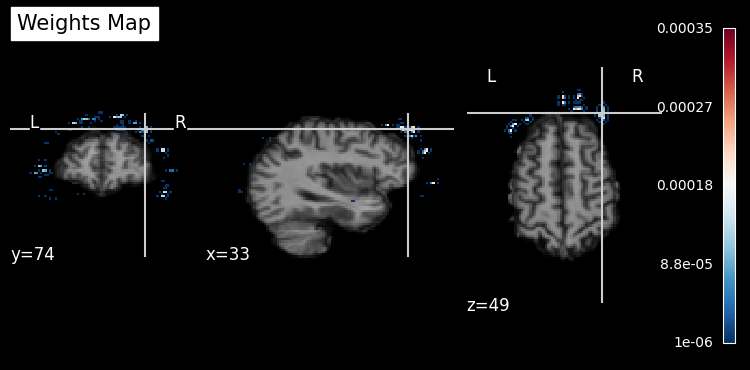

In [52]:
import numpy as np
import nibabel as nib
from nilearn.plotting import plot_stat_map
from nilearn import plotting, datasets, image
from os.path import join

# Load the weights
weights = np.load('/home/zkavian/thesis_code_git/masked_weights_session1_run1.npy')

# Load the anatomy
anat_img = nib.load(
    '/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/'
    'PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/'
    'Rev_pipeline/derivatives/sub-pd004/ses-1/anat/'
    'sub-pd004_ses-1_T1w_brain_2mm.nii.gz'
)
affine = anat_img.affine

run = 1
ses = 1
sub = '04'
base_path = '/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives'
data_name = f'sub-pd0{sub}_ses-{ses}_run-{run}_task-mv_bold_corrected_smoothed_reg_2mm.nii.gz'
BOLD_path_org = join(base_path, f'sub-pd0{sub}',f'ses-{ses}','func', data_name)


# Use the EPI header/affine for the weights image
epi_img = nib.load(BOLD_path_org)
# Create weights image in EPI space
weights_clean = np.nan_to_num(weights, nan=0.0)
weight_epi_img = image.new_img_like(epi_img, weights_clean, copy_header=True)
# Resample weights to anatomy space for plotting
weight_on_anat = image.resample_to_img(weight_epi_img, anat_img, interpolation='nearest', force_resample=True, copy_header=True)
# Plot
plot_stat_map(weight_on_anat, bg_img=anat_img, display_mode='ortho', title='Weights Map')


In [63]:
print(weight_img.affine)
print(anat_img.affine)


[[ 1.99804652e+00 -8.82647336e-02  0.00000000e+00 -8.57927170e+01]
 [ 8.82645175e-02  1.99805140e+00  0.00000000e+00 -1.15489983e+02]
 [ 0.00000000e+00  0.00000000e+00  2.00000000e+00 -7.48236389e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.99804652e+00 -8.82647336e-02  0.00000000e+00 -8.57927170e+01]
 [ 8.82645175e-02  1.99805140e+00  0.00000000e+00 -1.15489983e+02]
 [ 0.00000000e+00  0.00000000e+00  2.00000000e+00 -7.48236389e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


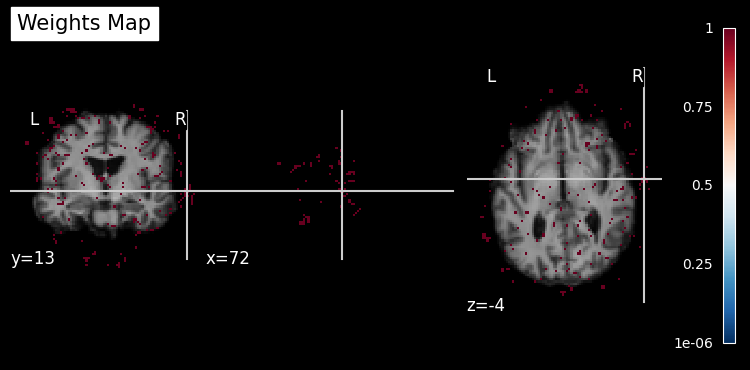

In [61]:
selected_img = nib.load('/home/zkavian/thesis_code_git/Optim_fMRI/affine_selected_active_low_var_voxels_session1_run1.nii.gz')
plot_stat_map(selected_img, bg_img=anat_img, display_mode='ortho', title='Weights Map')


In [66]:
from nilearn.image import new_img_like

anat_img = nib.as_closest_canonical(anat_img)
func_img = nib.as_closest_canonical(nib.load(BOLD_path_org))

# Map functional/GLM array orientation -> anatomy orientation
ornt_anat = nib.orientations.io_orientation(anat_img.affine)
ornt_func = nib.orientations.io_orientation(func_img.affine)
xform = nib.orientations.ornt_transform(ornt_func, ornt_anat)

active_low_var_voxels_reor = nib.orientations.apply_orientation(selected_img, xform)
# masked_weights_reor = nib.orientations.apply_orientation(masked_weights, xform)

# Create images that inherit the anatomy header (sform/qform + codes)
selected_voxels_img = new_img_like(anat_img, active_low_var_voxels_reor.astype(np.uint8))
# weight_img          = new_img_like(anat_img, masked_weights_reor)

# Plot (nearest avoids speckling due to interpolation)
from nilearn.plotting import plot_stat_map
plot_stat_map(selected_voxels_img, bg_img=anat_img, display_mode='ortho',
              resampling_interpolation='nearest', title='Weights Map')

OrientationError: Data array has fewer dimensions than orientation

In [71]:
selected_img.shape

(90, 128, 85)

In [57]:
print(nib.aff2axcodes(anat_img.affine), nib.aff2axcodes(weight_on_anat.affine)) #('R', 'A', 'S') ('R', 'A', 'S')

('R', 'A', 'S') ('R', 'A', 'S')


/tmp/ipykernel_11086/2958276301.py:1: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  plot_stat_map(image.mean_img(epi_img), bg_img=anat_img, display_mode='ortho', title='epi map')


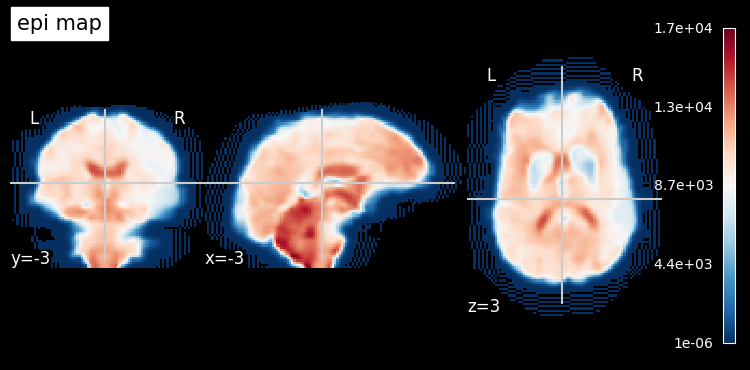

In [56]:

plot_stat_map(image.mean_img(epi_img), bg_img=anat_img, display_mode='ortho', title='epi map')

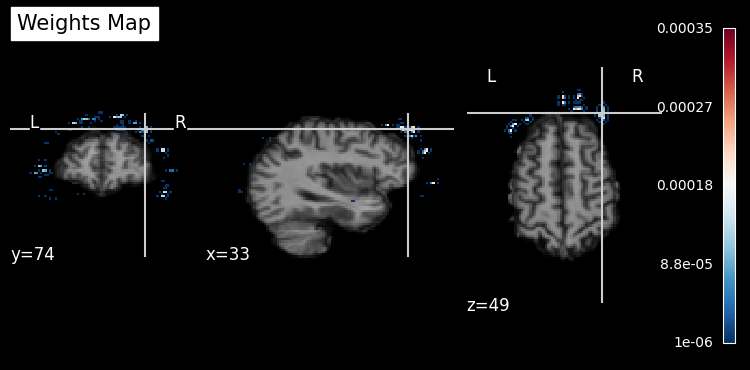

In [47]:
import numpy as np
import nibabel as nib
from nilearn.plotting import plot_stat_map

# Load the weights
weights = np.load('/home/zkavian/thesis_code_git/masked_weights_session1_run1.npy')

# Load the anatomy
anat_img = nib.load(
    '/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/'
    'PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/'
    'Rev_pipeline/derivatives/sub-pd004/ses-1/anat/'
    'sub-pd004_ses-1_T1w_brain_2mm.nii.gz'
)
affine = anat_img.affine

# Create a NIfTI image from the weights
weight_img = nib.Nifti1Image(weights, affine=affine)

# Replace NaNs with 0
data = weight_img.get_fdata()
data[np.isnan(data)] = 0

# Make a new NIfTI with cleaned data
clean_img = nib.Nifti1Image(data, affine=affine)

# Plot
plot_stat_map(clean_img, bg_img=anat_img, display_mode='ortho', title='Weights Map')


In [46]:
data = clean_img.get_fdata()
data.max()

np.float64(0.000353349547367543)

In [2]:
import numpy as np
y = np.load('/home/zkavian/thesis_code_git/reconstructed_sig_session1_run1.npy')
y.shape

(810,)

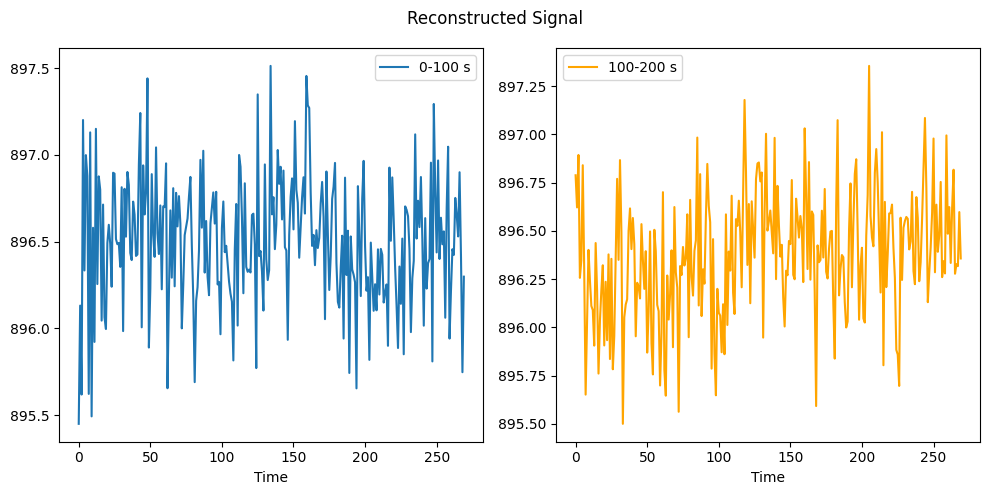

In [25]:
y = np.load('/home/zkavian/thesis_code_git/reconstructed_sig_session1_run1.npy')

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(y[:270], label='0-100 s')
axs[0].set_xlabel('Time')
axs[0].legend()
axs[1].plot(y[270:540], color = 'orange', label='100-200 s')
axs[1].set_xlabel('Time')
axs[1].legend()

fig.suptitle("Reconstructed Signal")
plt.tight_layout()
plt.show()

In [28]:
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

/tmp/ipykernel_68120/1365859771.py:103: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(B, axis=1)
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[1.36181154e-07 2.72362307e-07 4.08543461e-07 ... 4.99997276e-02
 4.99998638e-02 5.00000000e-02]
R^2 (percent) range: -7.60 .. 44.25
Significance: FDR q=0.05
Active voxels: 124599  (pos: 70341, neg: 54258)


/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_68120/1365859771.py:464: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  view = view_img(selected_voxels_img, bg_img=anat_img)  # shows sliders to move cuts
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_68120/1365859771.py:471: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  view = view_img(selected_vox

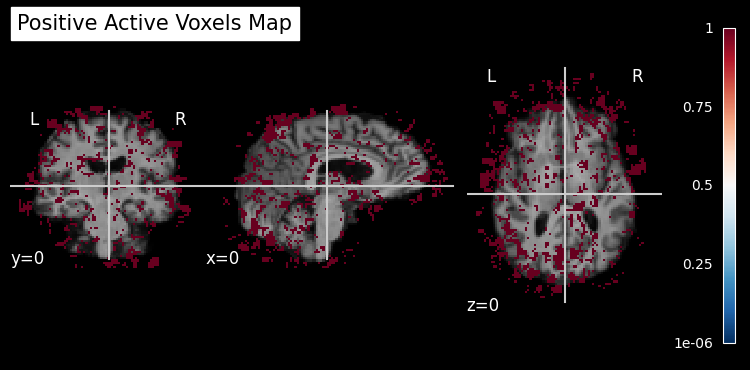

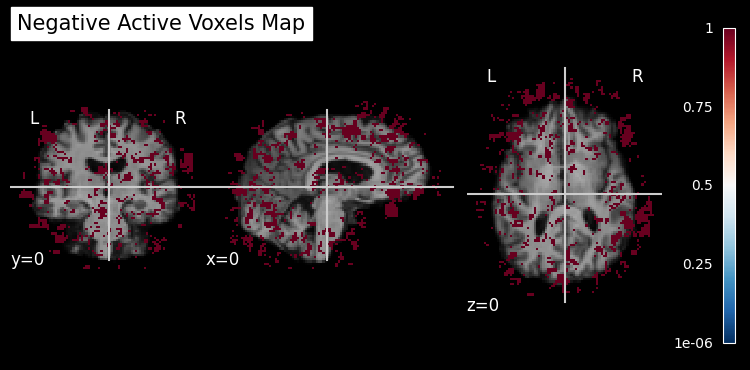

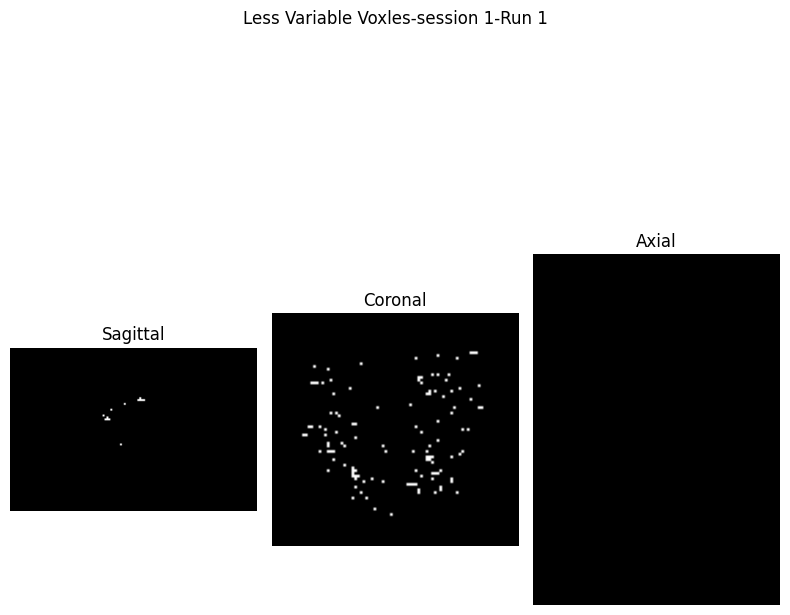

/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1361: RuntimeWarning: invalid value encountered in divide
  nval = ((n - 1.0) * n)**0.5 / (n - 2.0) * m3 / m2**1.5
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1469: RuntimeWarning: invalid value encountered in divide
  nval = 1.0/(n-2)/(n-3) * ((n**2-1.0)*m4/m2**2.0 - 3*(n-1)**2.0)


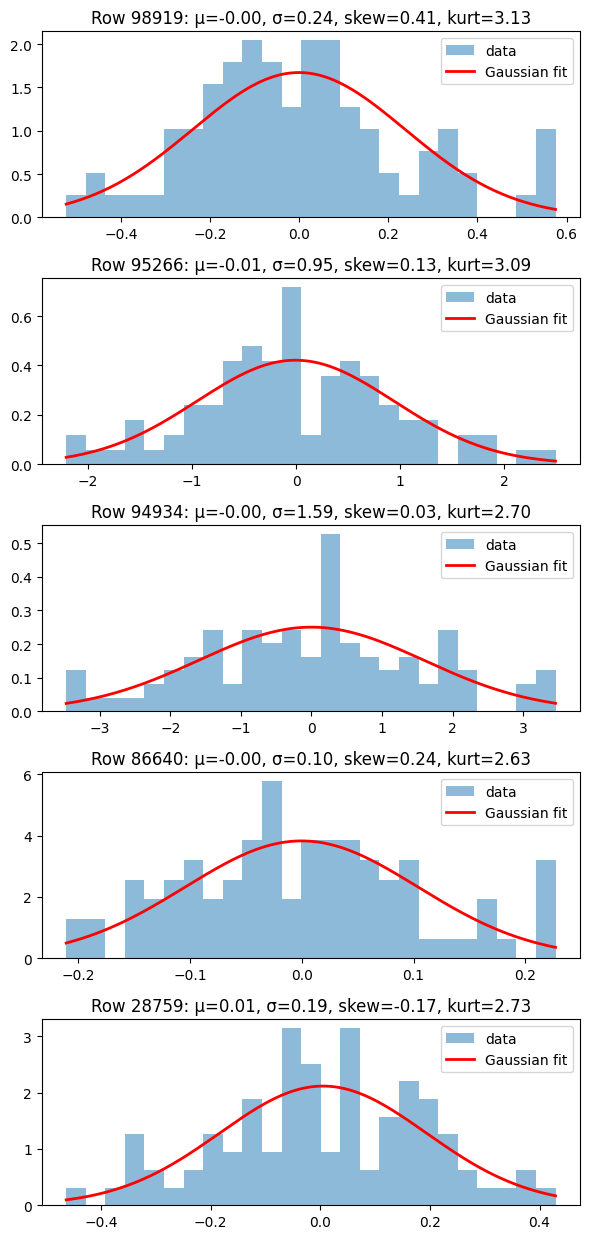

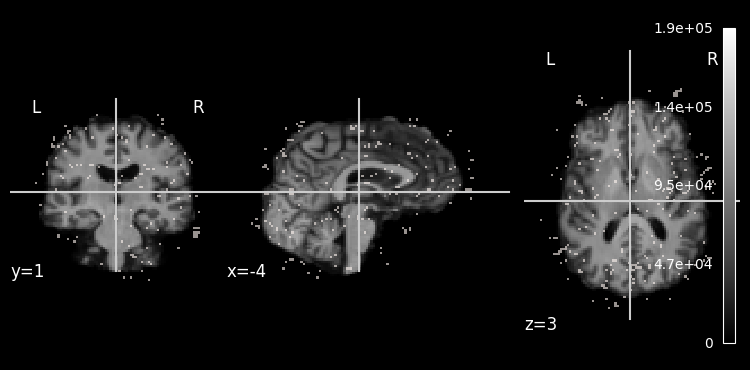

/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_68120/1365859771.py:490: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  view = view_img(selected_voxels_img, bg_img=anat_img)  # shows sliders to move cuts



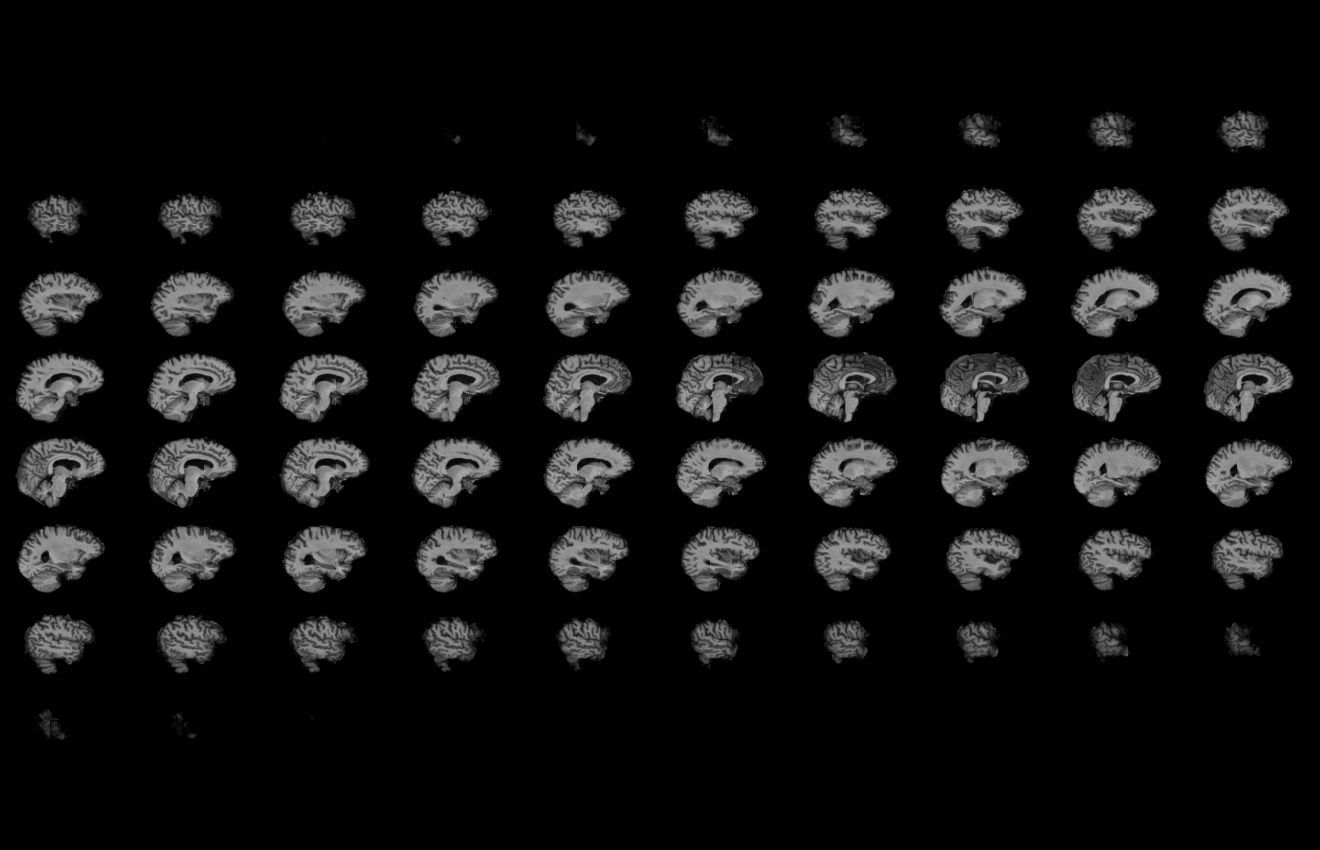
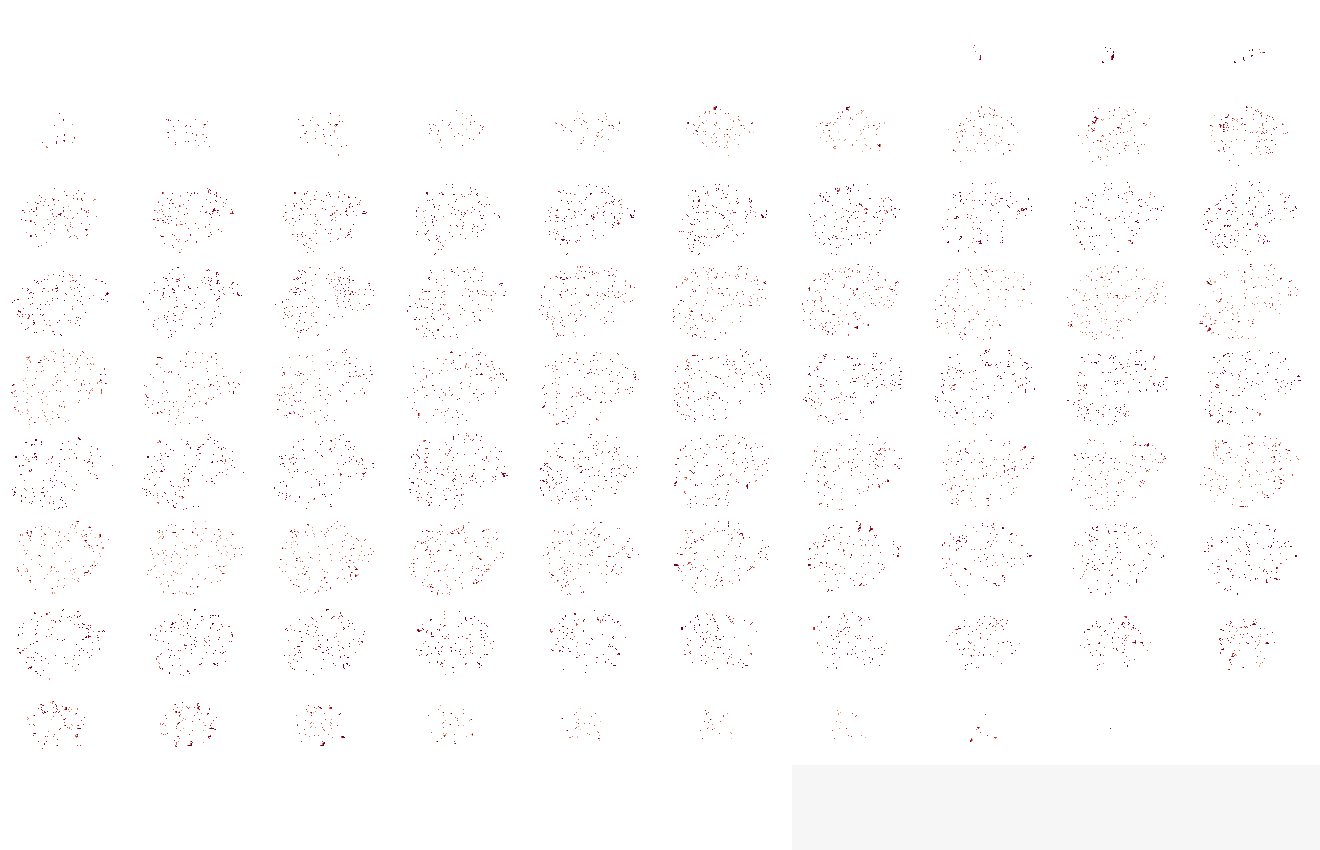

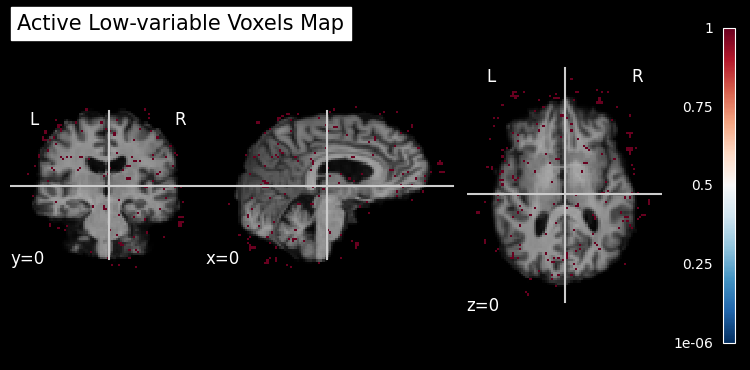

In [3]:
import nibabel as nib
import numpy as np
import matplotlib.pylab as plt
import cvxpy as cp
import pandas as pd
from os.path import join
from scipy import ndimage
from scipy.spatial.distance import cdist
from scipy.sparse import csgraph
from scipy.stats import skew, kurtosis, norm
from itertools import product
from sklearn.model_selection import KFold
from matplotlib.animation import FuncAnimation
from nilearn import plotting, datasets, image, masking
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map
from nilearn.plotting import view_img

import os, sys

def clear_console():
    if os.name == "nt":
        os.system("cls")                     # Windows
    else:
        # Try tput (nicer), fall back to ANSI reset
        os.system("tput reset 2>/dev/null || printf '\033c'")


# def find_active_voxels(glm_results, run, t_thr, R2_thr, brain_mask=None):
#     if run == 1:
#         betasmd = glm_results['betasmd'][:,:,:,0:90]
#         R2 = glm_results['R2run'][:,:,:,0]
#     else:
#         betasmd = glm_results['betasmd'][:,:,:,90:]
#         R2 = glm_results['R2run'][:,:,:,1]
    
#     print(f"R^2 range: {np.nanmin(R2)}-{np.nanmax(R2)}")
#     X, Y, Z, T = betasmd.shape
#     V = X * Y * Z 
#     B = betasmd.reshape(V, T)

#     n = np.sum(~np.isnan(B), axis=1) # number of valid (non-NaN) trials for each voxel
#     mu = np.nanmean(B, axis=1) 
#     sd = np.nanstd(B, axis=1, ddof=1)
#     se = sd / np.sqrt(np.clip(n, 1, None)); t = mu / se  #t-stat

#     mu_vol = mu.reshape(X, Y, Z)
#     sd_vol = sd.reshape(X, Y, Z)
#     n_vol  = n.reshape(X, Y, Z)
#     t_vol  = t.reshape(X, Y, Z)

#     base = (R2 > R2_thr) & (np.abs(t_vol) > t_thr)
#     if brain_mask is not None:
#         # ensure mask matches data shape
#         if brain_mask.shape != base.shape:
#             raise ValueError(f"brain_mask shape {brain_mask.shape} != data shape {base.shape}")
#         base &= brain_mask
#     mask_pos = base & (mu_vol > 0)
#     mask_neg = base & (mu_vol < 0)

#     clear_console()
#     print(f"Number of Active Voxels {np.sum(base)} from Total Voxels: {V}")
#     print(f"Number of Positively Active Voxels {np.sum(mask_pos)}, Number of Negatively Active Voxels {np.sum(mask_neg)}")
    
#     return betasmd, mask_pos, mask_neg



def find_active_voxels(glm_results, run, R2_thr=2.0, alpha=0.05, t_thr=None,
                       brain_mask=None, cluster_k=None):
    """
    Select active voxels by conjunction of:
      - significance of t-statistics (FDR q=alpha across voxels; or |t|>t_thr if provided)
      - GLMsingle R^2 (percent variance explained) > R2_thr (in PERCENT)
    Optional: restrict to brain_mask and drop clusters smaller than cluster_k voxels.

    Args:
        glm_results: dict from GLMsingle with keys 'betasmd' (X,Y,Z,T) and 'R2run' (X,Y,Z,run)
        run: 1 or 2 (selects R2run[:,:,:,0] or R2run[:,:,:,1] and the matching betas subset)
        R2_thr: float, percent variance explained threshold (e.g., 0 for lenient, 2–5 typical)
        alpha: FDR rate (ignored if t_thr is not None)
        t_thr: absolute t threshold; if None, uses FDR (recommended)
        brain_mask: optional boolean (X,Y,Z)
        cluster_k: optional int, minimum cluster size (voxels); requires scipy.ndimage if set

    Returns:
        betasmd, mask_pos, mask_neg (boolean volumes)
    """
    # --- pick run-specific data ---
    if run == 1:
        betasmd = glm_results['betasmd'][:,:,:,0:90]
        R2 = glm_results['R2run'][:,:,:,0]  # in PERCENT
    else:
        betasmd = glm_results['betasmd'][:,:,:,90:]
        R2 = glm_results['R2run'][:,:,:,1]  # in PERCENT

    X, Y, Z, T = betasmd.shape
    V = X * Y * Z
    B = betasmd.reshape(V, T)

    # --- t-statistics over trials (robust to NaNs) ---
    n = np.sum(~np.isnan(B), axis=1)                 # valid trial count per voxel
    mu = np.nanmean(B, axis=1)
    sd = np.nanstd(B, axis=1, ddof=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        se = sd / np.sqrt(np.clip(n, 1, None))
        t = mu / se
    t[~np.isfinite(t)] = np.nan  # n<2, zero variance, etc.

    mu_vol = mu.reshape(X, Y, Z)
    t_vol  = t.reshape(X, Y, Z)

    # --- significance mask: FDR (default) or hard t-threshold ---
    if t_thr is None:
        # Two-sided p-values for Student t; fallback to normal if SciPy missing
        # try:
        from scipy.stats import t as student_t
        df_vol = np.maximum(n - 1, 1).reshape(X, Y, Z)
        pvals = 2.0 * student_t.sf(np.abs(t_vol), df_vol)
        # except Exception:
        #     # Normal approximation fallback
        #     pvals = 2.0 * 0.5 * np.erfc(np.abs(t_vol) / np.sqrt(2.0))

        # Apply FDR on voxels we actually test
        valid = np.isfinite(pvals)
        if brain_mask is not None:
            if brain_mask.shape != (X, Y, Z):
                raise ValueError(f"brain_mask shape {brain_mask.shape} != data shape {(X,Y,Z)}")
            valid &= brain_mask

        p_vec = pvals[valid].ravel()
        m = p_vec.size
        if m == 0:
            mask_sig = np.zeros((X, Y, Z), dtype=bool)
        else:
            order = np.argsort(p_vec)
            ranked = p_vec[order]
            thresh = (np.arange(1, m + 1) / m) * alpha
            print(thresh)
            passing = ranked <= thresh
            mask_sig = np.zeros((X, Y, Z), dtype=bool)
            if np.any(passing):
                kmax = np.max(np.where(passing)[0])
                p_cut = ranked[kmax]
                tmp = np.zeros_like(p_vec, dtype=bool)
                tmp[:] = p_vec <= p_cut
                # map back
                mask_sig_flat = np.zeros(valid.sum(), dtype=bool)
                mask_sig_flat[:] = tmp
                mask_sig[valid] = mask_sig_flat
    else:
        # Hard threshold on |t|
        mask_sig = np.isfinite(t_vol) & (np.abs(t_vol) > float(t_thr))
        if brain_mask is not None:
            if brain_mask.shape != (X, Y, Z):
                raise ValueError(f"brain_mask shape {brain_mask.shape} != data shape {(X,Y,Z)}")
            mask_sig &= brain_mask

    # --- R^2 quality gate (percent) ---
    mask_R2 = np.isfinite(R2) & (R2 > float(R2_thr))
    if brain_mask is not None:
        mask_R2 &= brain_mask

    base = mask_sig & mask_R2

    # --- optional cluster-size pruning ---
    if cluster_k is not None and cluster_k > 1:
        try:
            from scipy.ndimage import label
            labeled, nlab = label(base)
            if nlab > 0:
                counts = np.bincount(labeled.ravel())
                keep = counts >= cluster_k
                keep[0] = False  # background
                base = keep[labeled]
        except Exception:
            print("Note: cluster_k specified but scipy.ndimage not available; skipping cluster filter.")

    mask_pos = base & (mu_vol > 0)
    mask_neg = base & (mu_vol < 0)

    # --- logging ---
    print(f"R^2 (percent) range: {np.nanmin(R2):.2f} .. {np.nanmax(R2):.2f}")
    if t_thr is None:
        print(f"Significance: FDR q={alpha}")
    else:
        print(f"Significance: |t| > {t_thr}")
    # print(f"R^2 threshold: > {R2_thr}%")
    if brain_mask is not None:
        print(f"Masked voxels considered: {brain_mask.sum()} / {V}")
    print(f"Active voxels: {int(base.sum())}  (pos: {int(mask_pos.sum())}, neg: {int(mask_neg.sum())})")

    return betasmd, mask_pos, mask_neg


def find_active_low_var_voxels(betasmd, mask_pos, mask_neg, sk_thr, kt_thr):
    mask_union = mask_pos | mask_neg
    beta_pos = betasmd[mask_union,:]
    beta_diff = np.diff(beta_pos, axis=1) #diff between consequence trial

    sk = skew(beta_diff, axis=1, bias=False)
    kt = kurtosis(beta_diff, axis=1, fisher=False, bias=False)
    mask_gaussian_like = (np.abs(sk) < sk_thr) & (np.abs(kt - 3) < kt_thr)

    selected_voxels = np.zeros(mask_pos.shape, dtype=bool)
    selected_voxels[mask_union] = mask_gaussian_like

    return selected_voxels, beta_diff

def plot_active_voxels(input, ses, run):
    fig, axes = plt.subplots(1, 3, figsize=(8, 8))
    ax_sag, ax_cor, ax_axial = axes
    fig.suptitle(f"Less Variable Voxles-session {ses}-Run {run}")

    x = input.shape[0] // 2
    y = input.shape[1] // 2
    z = input.shape[2] // 2

    im_sag = ax_sag.imshow(np.rot90(input[x, :, :]), cmap="gray", origin='lower')
    ax_sag.set_title("Sagittal")
    ax_sag.axis("off")


    im_cor = ax_cor.imshow(np.rot90(input[:, y, :]), cmap="gray", origin='lower')
    ax_cor.set_title("Coronal")        
    ax_cor.axis("off")

    im_ax = ax_axial.imshow(np.rot90(input[:, :, z]), cmap="gray", origin='lower')
    ax_axial.set_title("Axial")   
    ax_axial.axis("off")


    def update(i):
        im_sag.set_data(np.rot90(input[i, :, :]))      # sagittal slices
        im_cor.set_data(np.rot90(input[:, i, :]))      # coronal slices
        im_ax.set_data(np.rot90(input[:, :, i]))       # axial slices
        return im_sag, im_cor, im_ax

    ani = FuncAnimation(fig, update, frames=range(min(input.shape)), interval=100, blit=False)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    ani.save(filename=f"selected_voxels_session{ses}_run{run}.gif", writer="pillow")
    plt.show()

    return

def plot_dist(beta_diff, run, ses):
    mu    = beta_diff.mean(axis=1)
    sigma = beta_diff.std(axis=1, ddof=1)  
    sk    = skew(beta_diff, axis=1, bias=False)
    kt    = kurtosis(beta_diff, axis=1, fisher=False, bias=False)
    rows_to_show = np.random.choice(beta_diff.shape[0], 5, replace=False)

    fig, axes = plt.subplots(len(rows_to_show), 1, figsize=(6, 2.5*len(rows_to_show)))
    for ax, idx in zip(axes, rows_to_show):
        data = beta_diff[idx]
        m, s = mu[idx], sigma[idx]
        x = np.linspace(data.min(), data.max(), 200)

        ax.hist(data, bins=25, density=True, alpha=0.5, label='data')
        ax.plot(x, norm.pdf(x, m, s), 'r', lw=2, label='Gaussian fit')
        ax.set_title(f'Row {idx}: μ={m:.2f}, σ={s:.2f}, skew={sk[idx]:.2f}, kurt={kt[idx]:.2f}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    fig.savefig(f"beta_diff_selected_voxels_hist_session{ses}_run{run}.png", dpi=300, bbox_inches='tight')

    return

def plot_on_brain(anat_img, selected_img, save_path):
    display = plotting.plot_anat(anat_img, display_mode="ortho")
    display.add_overlay(selected_img, cmap="Reds", transparency=0.6, threshold=0.5)
    plotting.show()
    display.savefig(save_path)
    display.close()
    
    return

def calculate_matrices(betasmd, selected_voxels, anat_img, affine, BOLD_path_org, trial_indices, trial_len):
    ## L_task Vector (contains beta values for selected voxels)##
    num_total_trials = betasmd.shape[-1]
    if trial_indices is None:
        trial_indices = np.arange(num_total_trials)

    V1 = betasmd[selected_voxels.astype(bool), :][:, trial_indices]
    mean_V1 = np.mean(V1, axis=-1)
    L_task = np.divide(1., np.abs(mean_V1), out=np.zeros_like(mean_V1), where=mean_V1 != 0)
    # L_task = 1./np.abs(mean_V1)


    BOLD_data = nib.load(BOLD_path_org).get_fdata() #(90, 128, 85, 850)
    selected_BOLD_data = BOLD_data[selected_voxels.astype(bool), :]
    selected_BOLD_data_reshape = np.zeros((selected_BOLD_data.shape[0], num_total_trials, trial_len))
    start = 0
    for i in range(num_trials):
        selected_BOLD_data_reshape[:, i, :] = selected_BOLD_data[:, start:start+trial_len]
        start += trial_len
        if start == 270 or start == 560:
            start += 20

    print(selected_BOLD_data_reshape.shape)
    selected_BOLD_data_subset = selected_BOLD_data_reshape[:, trial_indices, :]
    print(selected_BOLD_data_subset.shape)

    ## L_var matrix (contains variance of selected voxels)##
    diff_mat = np.diff(selected_BOLD_data_subset, axis=1)
    diff_mat_flat = diff_mat.reshape(diff_mat.shape[0], -1)
    L_var = np.cov(diff_mat_flat, bias=False)
    L_var = (L_var + L_var.T) / 2 + 1e-6 * np.eye(L_var.shape[0])
    # C2 = diff_mat_flat @ diff_mat_flat.T
    # L_var = C2 / selected_BOLD_data_reshape.shape[1]


    ## L_smooth matrix (contains distance beyween selected voxels)##
    anat_img_shape = anat_img.shape
    coords = np.array(np.meshgrid(
        np.arange(anat_img_shape[0]),
        np.arange(anat_img_shape[1]),
        np.arange(anat_img_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T

    # Convert to world (scanner/MNI) coordinates
    world_coords = nib.affines.apply_affine(affine, coords)
    tmp = selected_voxels.astype(bool).reshape(-1)
    selected_world_coords = world_coords[tmp,:]
    D = cdist(selected_world_coords, selected_world_coords)
    sigma = np.median(D[D>0])
    W = np.exp(-D**2 / (2*sigma**2))      # similarity
    np.fill_diagonal(W, 0.0)
    L_smooth = csgraph.laplacian(W, normed=False)
    # L_smooth = csgraph.laplacian(D)

    return L_task, L_var, L_smooth, selected_BOLD_data_subset.reshape(selected_BOLD_data_subset.shape[0], -1)

def objective_func(w, L_task, L_var, L_smooth,
              alpha_var, alpha_smooth):
    """Value of the full loss on a validation set."""
    quad = (w.T @ np.diag(L_task) @ w
            + alpha_var   * (w.T @ L_var    @ w)
            + alpha_smooth * (w.T @ L_smooth @ w))
    # l1 = alpha_sparse * np.sum(np.abs(w))
    return quad

def optimize_voxel_weights(
    L_task: np.ndarray,
    L_var: np.ndarray,
    L_smooth: np.ndarray,
    alpha_var: float = 1.0,
    alpha_smooth: float = 0.1):
    
    L_total = np.diag(L_task) + alpha_var * L_var + alpha_smooth * L_smooth
    n = L_total.shape[0]
    L_total = 0.5*(L_total + L_total.T) + 1e-8*np.eye(n)
    w = cp.Variable(n, nonneg=True)
    constraints = [cp.sum(w) == 1]
    
    # objective = cp.Minimize(cp.quad_form(w, L_total) + alpha_sparse * cp.norm1(w))
    objective = cp.Minimize(cp.quad_form(w, L_total))
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.OSQP, verbose=True)
    return w.value

def calculate_weight(param_grid, betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, trial_len):
    kf = KFold(n_splits=2, shuffle=True, random_state=0)
    best_score = np.inf
    best_params = None
    num_trials = betasmd.shape[-1]

    for a_var, a_smooth in product(*param_grid.values()):
        fold_scores = []
        print(f"a_var: {a_var}, a_smooth: {a_smooth}")
        count = 1

        for train_idx, val_idx in kf.split(np.arange(num_trials)):
            clear_console()
            print(f"k-fold num: {count}")
            L_task_train, L_var_train, L_smooth_train, _ = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, train_idx, trial_len)
            w = optimize_voxel_weights(L_task_train, L_var_train, L_smooth_train, alpha_var=a_var, alpha_smooth=a_smooth)

            L_task_val, L_var_val, L_smooth_val, _ = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, val_idx, trial_len)

            fold_scores.append(objective_func(w, L_task_val, L_var_val, L_smooth_val, a_var, a_smooth))
            print(f"fold_scores: {fold_scores}")
            count += 1

        mean_score = np.mean(fold_scores)
        print(mean_score)
        if mean_score < best_score:
            best_score = mean_score
            best_params = (a_var, a_smooth)

    clear_console()
    print("Best parameters:", best_params, "with CV loss:", best_score)
    return best_params, best_score

def select_opt_weight(selected_BOLD_data, weights, selected_voxels, affine):
    y = selected_BOLD_data.T @ weights
    p95 = np.percentile(weights, 95)

    weight_volume = np.zeros(selected_voxels.shape, dtype=np.float32)
    weight_volume[selected_voxels] = weights  # put weights in their voxel positions

    mask = np.zeros(selected_voxels.shape, dtype=bool)
    # Keep only the top 5% strongest weights
    selected_weights = (weights >= p95)
    mask[selected_voxels] = selected_weights
    weight_volume[~mask] = 0

    masked_weights = np.where(weight_volume == 0, np.nan, weight_volume)
    weight_img = nib.Nifti1Image(masked_weights, affine=affine)
    
    return weight_img, masked_weights, y

# %% 
t_thr = 3
R2_thr = 1.5
sk_thr = 0.1 
kt_thr = 0.2
run = 1
ses = 1
sub = '04'
num_trials = 90
trial_len = 9

# param_grid = {
#     "alpha_var":   [0.5, 1.0, 10.0],
#     "alpha_smooth":[0.5, 0.1, 1.0],
#     "alpha_sparse":[0.001, 0.01, 0.1]}

param_grid = {
    "alpha_var":   [0.5, 1.0],
    "alpha_smooth":[0.5, 1.0]}

# Use the same subject/session across GLMsingle results, anatomy, and BOLD
glm_result_path = (
    f"/mnt/TeamShare/Data_Masterfile/Zahra-Thesis-Data/Master_Thesis_Files/GLM_single_results/"
    f"GLMOutputs2-sub{sub}-ses0{ses}/TYPED_FITHRF_GLMDENOISE_RR.npy"
)
anat_img = nib.load(f'/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain_2mm.nii.gz')
base_path = '/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives'
data_name = f'sub-pd0{sub}_ses-{ses}_run-{run}_task-mv_bold_corrected_smoothed_reg_2mm.nii.gz'
BOLD_path_org = join(base_path, f'sub-pd0{sub}', f'ses-{ses}', 'func', data_name)

glm_results = np.load(glm_result_path, allow_pickle=True).item()

# Build a conservative brain mask from skull-stripped T1
brain_mask_img = masking.compute_brain_mask(anat_img)
brain_mask = brain_mask_img.get_fdata().astype(bool)

anat_img = nib.as_closest_canonical(anat_img)
func_img = nib.as_closest_canonical(nib.load(BOLD_path_org))
ornt_anat = nib.orientations.io_orientation(anat_img.affine)
ornt_func = nib.orientations.io_orientation(func_img.affine)
xform = nib.orientations.ornt_transform(ornt_func, ornt_anat)

# betasmd, mask_pos, mask_neg = find_active_voxels(glm_results, run, t_thr, R2_thr, brain_mask=brain_mask)
betasmd, mask_pos, mask_neg = find_active_voxels(glm_results, run=1, R2_thr=2.0, alpha=0.05)

pos_native = nib.orientations.apply_orientation(mask_pos, xform)
selected_voxels_img = new_img_like(anat_img, pos_native.astype(np.uint8))
plot_stat_map(selected_voxels_img, bg_img=anat_img, display_mode='ortho',
              resampling_interpolation='nearest', title='Positive Active Voxels Map', cut_coords=(0,0,0))
view = view_img(selected_voxels_img, bg_img=anat_img)  # shows sliders to move cuts
view

neg_native = nib.orientations.apply_orientation(mask_neg, xform)
selected_voxels_img = new_img_like(anat_img, neg_native.astype(np.uint8))
plot_stat_map(selected_voxels_img, bg_img=anat_img, display_mode='ortho',
              resampling_interpolation='nearest', title='Negative Active Voxels Map', cut_coords=(0,0,0))
view = view_img(selected_voxels_img, bg_img=anat_img)  # shows sliders to move cuts
view


active_low_var_voxels, beta_diff = find_active_low_var_voxels(betasmd, mask_pos, mask_neg, sk_thr, kt_thr)
plot_active_voxels(active_low_var_voxels, ses, run)
plot_dist(beta_diff, run, ses)

anat_data = anat_img.get_fdata()
affine = anat_img.affine
selected_voxels = nib.Nifti1Image(active_low_var_voxels.astype(np.uint8), affine)
nib.save(selected_voxels, f'affine_selected_active_low_var_voxels_session{ses}_run{run}.nii.gz')
save_path = f"anat_with_overlay(active_low_var_voxels_session{ses}_run{run}).png"
plot_on_brain(anat_img, selected_voxels, save_path)

active_low_var_voxels_reor = nib.orientations.apply_orientation(active_low_var_voxels, xform)
selected_voxels_img = new_img_like(anat_img, active_low_var_voxels_reor.astype(np.uint8))
plot_stat_map(selected_voxels_img, bg_img=anat_img, display_mode='ortho',
              resampling_interpolation='nearest', title='Active Low-variable Voxels Map', cut_coords=(0,0,0))
view = view_img(selected_voxels_img, bg_img=anat_img)  # shows sliders to move cuts
view

/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_68120/1919457113.py:5: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  view = view_img(selected_voxels_img, bg_img=anat_img, cmap='Reds')  # shows sliders to move cuts


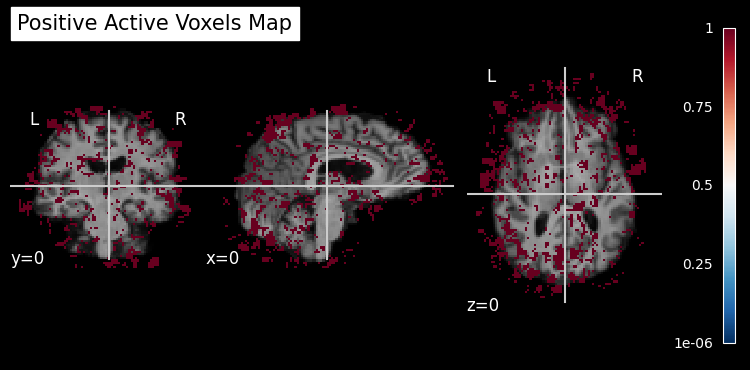

In [10]:
pos_native = nib.orientations.apply_orientation(mask_pos, xform)
selected_voxels_img = new_img_like(anat_img, pos_native.astype(np.uint8))
plot_stat_map(selected_voxels_img, bg_img=anat_img, display_mode='ortho',
              resampling_interpolation='nearest', title='Positive Active Voxels Map', cut_coords=(0,0,0))
view = view_img(selected_voxels_img, bg_img=anat_img, cmap='Reds')  # shows sliders to move cuts
view
view.save_as_html("negative_active_brain_view_sub04_run01.html")

/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_68120/2512091837.py:5: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  view = view_img(selected_voxels_img, bg_img=anat_img, cmap='jet')  # shows sliders to move cuts


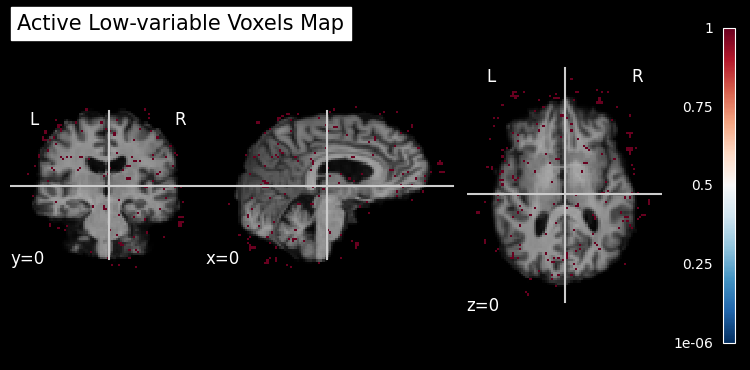

In [11]:
active_low_var_voxels_reor = nib.orientations.apply_orientation(active_low_var_voxels, xform)
selected_voxels_img = new_img_like(anat_img, active_low_var_voxels_reor.astype(np.uint8))
plot_stat_map(selected_voxels_img, bg_img=anat_img, display_mode='ortho',
              resampling_interpolation='nearest', title='Active Low-variable Voxels Map', cut_coords=(0,0,0))
view = view_img(selected_voxels_img, bg_img=anat_img, cmap='jet')  # shows sliders to move cuts
view.save_as_html("low_var_active_brain_view_sub04_run01.html")

a_var: 0.5, a_smooth: 0.5
ck-fold num: 1
(10394, 90, 9)
(10394, 45, 9)


(CVXPY) Sep 04 05:10:50 PM: Your problem has 10394 variables, 1 constraints, and 0 parameters.


                                     CVXPY                                     
                                     v1.7.2                                    


(CVXPY) Sep 04 05:11:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 04 05:11:03 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 04 05:11:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Sep 04 05:11:03 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Sep 04 05:11:03 PM: Compiling problem (target solver=OSQP).
(CVXPY) Sep 04 05:11:03 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Sep 04 05:11:03 PM: Applying reduction CvxAttr2Constr
(CVXPY) Sep 04 05:11:03 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Sep 04 05:11:03 PM: Applying reduction QpMatrixStuffing


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Sep 04 05:11:12 PM: Applying reduction OSQP
(CVXPY) Sep 04 05:11:19 PM: Finished problem compilation (took 1.577e+01 seconds).
(CVXPY) Sep 04 05:11:19 PM: Invoking solver OSQP  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 10394, constraints m = 10395
          nnz(P) + nnz(A) = 54043603
settings: algebra = Built-in,
          OSQPInt = 4 bytes, OSQPFloat = 8 bytes,
          linear system solver = QDLDL v0.1.8,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive: 50 iterations),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25, duality gap: on),
          time_limit: 1.00e+10 s

(CVXPY) Sep 04 05:16:48 PM: Problem status: optimal
(CVXPY) Sep 04 05:16:48 PM: Optimal value: 4.230e-01
(CVXPY) Sep 04 05:16:48 PM: Compilation took 1.577e+01 seconds
(CVXPY) Sep 04 05:16:48 PM: Solver (including time spent in interface) took 3.285e+02 seconds


plsh   4.2303e-01   3.95e-15   1.86e-11  -1.80e-11   1.86e-11   --------    3.27e+02s

status:               solved
solution polishing:   successful
number of iterations: 1275
optimal objective:    0.4230
dual objective:       0.4230
duality gap:          -1.8011e-11
primal-dual integral: 4.5489e+05
run time:             3.27e+02s
optimal rho estimate: 4.96e-02

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(10394, 90, 9)
(10394, 45, 9)
fold_scores: [np.float64(0.9039052745477496)]
ck-fold num: 2
(10394, 90, 9)
(10394, 45, 9)


(CVXPY) Sep 04 05:17:20 PM: Your problem has 10394 variables, 1 constraints, and 0 parameters.


                                     CVXPY                                     
                                     v1.7.2                                    


(CVXPY) Sep 04 05:17:34 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 04 05:17:34 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 04 05:17:34 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Sep 04 05:17:34 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Sep 04 05:17:34 PM: Compiling problem (target solver=OSQP).
(CVXPY) Sep 04 05:17:34 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Sep 04 05:17:34 PM: Applying reduction CvxAttr2Constr
(CVXPY) Sep 04 05:17:34 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Sep 04 05:17:34 PM: Applying reduction QpMatrixStuffing


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Sep 04 05:17:43 PM: Applying reduction OSQP
(CVXPY) Sep 04 05:17:49 PM: Finished problem compilation (took 1.566e+01 seconds).
(CVXPY) Sep 04 05:17:49 PM: Invoking solver OSQP  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 10394, constraints m = 10395
          nnz(P) + nnz(A) = 54043603
settings: algebra = Built-in,
          OSQPInt = 4 bytes, OSQPFloat = 8 bytes,
          linear system solver = QDLDL v0.1.8,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive: 50 iterations),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25, duality gap: on),
          time_limit: 1.00e+10 s

(CVXPY) Sep 04 05:23:32 PM: Problem status: optimal
(CVXPY) Sep 04 05:23:32 PM: Optimal value: 4.599e-01
(CVXPY) Sep 04 05:23:32 PM: Compilation took 1.566e+01 seconds
(CVXPY) Sep 04 05:23:32 PM: Solver (including time spent in interface) took 3.423e+02 seconds


plsh   4.5989e-01   1.02e-15   5.33e-12  -4.56e-12   5.33e-12   --------    3.41e+02s

status:               solved
solution polishing:   successful
number of iterations: 1425
optimal objective:    0.4599
dual objective:       0.4599
duality gap:          -4.5553e-12
primal-dual integral: 4.5493e+05
run time:             3.41e+02s
optimal rho estimate: 5.36e-02

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(10394, 90, 9)
(10394, 45, 9)
fold_scores: [np.float64(0.9039052745477496), np.float64(0.6782018154491871)]
0.7910535449984684
a_var: 0.5, a_smooth: 1.0
k-fold num: 1
c(10394, 90, 9)
(10394, 45, 9)


(CVXPY) Sep 04 05:24:05 PM: Your problem has 10394 variables, 1 constraints, and 0 parameters.


                                     CVXPY                                     
                                     v1.7.2                                    


(CVXPY) Sep 04 05:24:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 04 05:24:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 04 05:24:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Sep 04 05:24:17 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Sep 04 05:24:17 PM: Compiling problem (target solver=OSQP).
(CVXPY) Sep 04 05:24:17 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Sep 04 05:24:17 PM: Applying reduction CvxAttr2Constr
(CVXPY) Sep 04 05:24:17 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Sep 04 05:24:17 PM: Applying reduction QpMatrixStuffing


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Sep 04 05:24:26 PM: Applying reduction OSQP
(CVXPY) Sep 04 05:24:33 PM: Finished problem compilation (took 1.598e+01 seconds).
(CVXPY) Sep 04 05:24:33 PM: Invoking solver OSQP  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 10394, constraints m = 10395
          nnz(P) + nnz(A) = 54043603
settings: algebra = Built-in,
          OSQPInt = 4 bytes, OSQPFloat = 8 bytes,
          linear system solver = QDLDL v0.1.8,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive: 50 iterations),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25, duality gap: on),
          time_limit: 1.00e+10 s

(CVXPY) Sep 04 05:29:51 PM: Problem status: optimal
(CVXPY) Sep 04 05:29:51 PM: Optimal value: 7.756e-01
(CVXPY) Sep 04 05:29:51 PM: Compilation took 1.598e+01 seconds
(CVXPY) Sep 04 05:29:51 PM: Solver (including time spent in interface) took 3.176e+02 seconds


plsh   7.7561e-01   1.88e-15   1.82e-11  -1.76e-11   1.82e-11   --------    3.16e+02s

status:               solved
solution polishing:   successful
number of iterations: 1075
optimal objective:    0.7756
dual objective:       0.7756
duality gap:          -1.7571e-11
primal-dual integral: 9.0961e+05
run time:             3.16e+02s
optimal rho estimate: 5.22e-02

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(10394, 90, 9)
(10394, 45, 9)
fold_scores: [np.float64(1.428696317661939)]
k-fold num: 2
c(10394, 90, 9)
(10394, 45, 9)


(CVXPY) Sep 04 05:30:23 PM: Your problem has 10394 variables, 1 constraints, and 0 parameters.


                                     CVXPY                                     
                                     v1.7.2                                    


(CVXPY) Sep 04 05:30:33 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 04 05:30:33 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 04 05:30:33 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Sep 04 05:30:33 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Sep 04 05:30:33 PM: Compiling problem (target solver=OSQP).
(CVXPY) Sep 04 05:30:33 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Sep 04 05:30:33 PM: Applying reduction CvxAttr2Constr
(CVXPY) Sep 04 05:30:33 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Sep 04 05:30:33 PM: Applying reduction QpMatrixStuffing


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Sep 04 05:30:42 PM: Applying reduction OSQP
(CVXPY) Sep 04 05:30:49 PM: Finished problem compilation (took 1.567e+01 seconds).
(CVXPY) Sep 04 05:30:49 PM: Invoking solver OSQP  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 10394, constraints m = 10395
          nnz(P) + nnz(A) = 54043603
settings: algebra = Built-in,
          OSQPInt = 4 bytes, OSQPFloat = 8 bytes,
          linear system solver = QDLDL v0.1.8,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive: 50 iterations),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25, duality gap: on),
          time_limit: 1.00e+10 s

(CVXPY) Sep 04 05:36:23 PM: Problem status: optimal
(CVXPY) Sep 04 05:36:23 PM: Optimal value: 8.451e-01
(CVXPY) Sep 04 05:36:23 PM: Compilation took 1.567e+01 seconds
(CVXPY) Sep 04 05:36:23 PM: Solver (including time spent in interface) took 3.339e+02 seconds


plsh   8.4512e-01   5.28e-15   4.90e-11  -4.81e-11   4.90e-11   --------    3.32e+02s

status:               solved
solution polishing:   successful
number of iterations: 1200
optimal objective:    0.8451
dual objective:       0.8451
duality gap:          -4.8132e-11
primal-dual integral: 9.0965e+05
run time:             3.32e+02s
optimal rho estimate: 5.91e-02

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(10394, 90, 9)
(10394, 45, 9)
fold_scores: [np.float64(1.428696317661939), np.float64(1.1216595876190252)]
1.275177952640482
a_var: 1.0, a_smooth: 0.5
ck-fold num: 1
(10394, 90, 9)
(10394, 45, 9)


(CVXPY) Sep 04 05:36:57 PM: Your problem has 10394 variables, 1 constraints, and 0 parameters.


                                     CVXPY                                     
                                     v1.7.2                                    


(CVXPY) Sep 04 05:37:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 04 05:37:25 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 04 05:37:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Sep 04 05:37:25 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Sep 04 05:37:25 PM: Compiling problem (target solver=OSQP).
(CVXPY) Sep 04 05:37:25 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Sep 04 05:37:25 PM: Applying reduction CvxAttr2Constr
(CVXPY) Sep 04 05:37:25 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Sep 04 05:37:25 PM: Applying reduction QpMatrixStuffing


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Sep 04 05:37:35 PM: Applying reduction OSQP
(CVXPY) Sep 04 05:37:42 PM: Finished problem compilation (took 1.773e+01 seconds).
(CVXPY) Sep 04 05:37:42 PM: Invoking solver OSQP  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 10394, constraints m = 10395
          nnz(P) + nnz(A) = 54043603
settings: algebra = Built-in,
          OSQPInt = 4 bytes, OSQPFloat = 8 bytes,
          linear system solver = QDLDL v0.1.8,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive: 50 iterations),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25, duality gap: on),
          time_limit: 1.00e+10 s

(CVXPY) Sep 04 05:44:07 PM: Problem status: optimal
(CVXPY) Sep 04 05:44:07 PM: Optimal value: 4.559e-01
(CVXPY) Sep 04 05:44:07 PM: Compilation took 1.773e+01 seconds
(CVXPY) Sep 04 05:44:07 PM: Solver (including time spent in interface) took 3.842e+02 seconds



status:               solved
solution polishing:   unsuccessful
number of iterations: 1450
optimal objective:    0.4558
dual objective:       0.4559
duality gap:          -1.7776e-05
primal-dual integral: 4.5530e+05
run time:             3.82e+02s
optimal rho estimate: 4.28e-02

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(10394, 90, 9)
(10394, 45, 9)
fold_scores: [np.float64(1.1786194004386898)]
k-fold num: 2
c(10394, 90, 9)
(10394, 45, 9)


(CVXPY) Sep 04 05:44:43 PM: Your problem has 10394 variables, 1 constraints, and 0 parameters.


                                     CVXPY                                     
                                     v1.7.2                                    


(CVXPY) Sep 04 05:45:11 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 04 05:45:11 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 04 05:45:11 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Sep 04 05:45:11 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Sep 04 05:45:11 PM: Compiling problem (target solver=OSQP).
(CVXPY) Sep 04 05:45:11 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Sep 04 05:45:11 PM: Applying reduction CvxAttr2Constr
(CVXPY) Sep 04 05:45:11 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Sep 04 05:45:11 PM: Applying reduction QpMatrixStuffing


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Sep 04 05:45:21 PM: Applying reduction OSQP
(CVXPY) Sep 04 05:45:29 PM: Finished problem compilation (took 1.801e+01 seconds).
(CVXPY) Sep 04 05:45:29 PM: Invoking solver OSQP  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 10394, constraints m = 10395
          nnz(P) + nnz(A) = 54043603
settings: algebra = Built-in,
          OSQPInt = 4 bytes, OSQPFloat = 8 bytes,
          linear system solver = QDLDL v0.1.8,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive: 50 iterations),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25, duality gap: on),
          time_limit: 1.00e+10 s

(CVXPY) Sep 04 05:52:08 PM: Problem status: optimal
(CVXPY) Sep 04 05:52:08 PM: Optimal value: 4.953e-01
(CVXPY) Sep 04 05:52:08 PM: Compilation took 1.801e+01 seconds
(CVXPY) Sep 04 05:52:08 PM: Solver (including time spent in interface) took 3.997e+02 seconds


plsh   4.9531e-01   2.30e-15   1.13e-11   1.06e-11   1.13e-11   --------    3.98e+02s

status:               solved
solution polishing:   successful
number of iterations: 1650
optimal objective:    0.4953
dual objective:       0.4953
duality gap:          1.0624e-11
primal-dual integral: 4.5535e+05
run time:             3.98e+02s
optimal rho estimate: 4.33e-02

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(10394, 90, 9)
(10394, 45, 9)
fold_scores: [np.float64(1.1786194004386898), np.float64(0.8393533765969501)]
1.0089863885178199
a_var: 1.0, a_smooth: 1.0
ck-fold num: 1
(10394, 90, 9)
(10394, 45, 9)


(CVXPY) Sep 04 05:52:43 PM: Your problem has 10394 variables, 1 constraints, and 0 parameters.


                                     CVXPY                                     
                                     v1.7.2                                    


(CVXPY) Sep 04 05:53:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 04 05:53:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 04 05:53:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Sep 04 05:53:02 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Sep 04 05:53:02 PM: Compiling problem (target solver=OSQP).
(CVXPY) Sep 04 05:53:02 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Sep 04 05:53:02 PM: Applying reduction CvxAttr2Constr
(CVXPY) Sep 04 05:53:02 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Sep 04 05:53:02 PM: Applying reduction QpMatrixStuffing


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Sep 04 05:53:12 PM: Applying reduction OSQP
(CVXPY) Sep 04 05:53:20 PM: Finished problem compilation (took 1.756e+01 seconds).
(CVXPY) Sep 04 05:53:20 PM: Invoking solver OSQP  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 10394, constraints m = 10395
          nnz(P) + nnz(A) = 54043603
settings: algebra = Built-in,
          OSQPInt = 4 bytes, OSQPFloat = 8 bytes,
          linear system solver = QDLDL v0.1.8,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive: 50 iterations),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25, duality gap: on),
          time_limit: 1.00e+10 s

(CVXPY) Sep 04 05:59:34 PM: Problem status: optimal
(CVXPY) Sep 04 05:59:34 PM: Optimal value: 8.454e-01
(CVXPY) Sep 04 05:59:34 PM: Compilation took 1.756e+01 seconds
(CVXPY) Sep 04 05:59:34 PM: Solver (including time spent in interface) took 3.743e+02 seconds


plsh   8.4537e-01   2.68e-15   2.67e-11  -2.52e-11   2.67e-11   --------    3.72e+02s

status:               solved
solution polishing:   successful
number of iterations: 1325
optimal objective:    0.8454
dual objective:       0.8454
duality gap:          -2.5223e-11
primal-dual integral: 9.1027e+05
run time:             3.72e+02s
optimal rho estimate: 4.96e-02

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(10394, 90, 9)
(10394, 45, 9)
fold_scores: [np.float64(1.8080209784065433)]
k-fold num: 2
c(10394, 90, 9)
(10394, 45, 9)


(CVXPY) Sep 04 06:00:09 PM: Your problem has 10394 variables, 1 constraints, and 0 parameters.


                                     CVXPY                                     
                                     v1.7.2                                    


(CVXPY) Sep 04 06:00:27 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 04 06:00:27 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 04 06:00:27 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Sep 04 06:00:27 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Sep 04 06:00:27 PM: Compiling problem (target solver=OSQP).
(CVXPY) Sep 04 06:00:27 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Sep 04 06:00:27 PM: Applying reduction CvxAttr2Constr
(CVXPY) Sep 04 06:00:27 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Sep 04 06:00:27 PM: Applying reduction QpMatrixStuffing


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Sep 04 06:00:37 PM: Applying reduction OSQP
(CVXPY) Sep 04 06:00:44 PM: Finished problem compilation (took 1.762e+01 seconds).
(CVXPY) Sep 04 06:00:44 PM: Invoking solver OSQP  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 10394, constraints m = 10395
          nnz(P) + nnz(A) = 54043603
settings: algebra = Built-in,
          OSQPInt = 4 bytes, OSQPFloat = 8 bytes,
          linear system solver = QDLDL v0.1.8,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive: 50 iterations),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25, duality gap: on),
          time_limit: 1.00e+10 s

(CVXPY) Sep 04 06:07:13 PM: Problem status: optimal
(CVXPY) Sep 04 06:07:13 PM: Optimal value: 9.191e-01
(CVXPY) Sep 04 06:07:13 PM: Compilation took 1.762e+01 seconds
(CVXPY) Sep 04 06:07:13 PM: Solver (including time spent in interface) took 3.891e+02 seconds


plsh   9.1908e-01   2.08e-16   1.87e-12   1.17e-12   1.87e-12   --------    3.87e+02s

status:               solved
solution polishing:   successful
number of iterations: 1475
optimal objective:    0.9191
dual objective:       0.9191
duality gap:          1.1719e-12
primal-dual integral: 9.1034e+05
run time:             3.87e+02s
optimal rho estimate: 5.29e-02

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(10394, 90, 9)
(10394, 45, 9)
fold_scores: [np.float64(1.8080209784065433), np.float64(1.3560803254030014)]
1.5820506519047723
cBest parameters: (0.5, 0.5) with CV loss: 0.7910535449984684
(10394, 90, 9)
(10394, 90, 9)


(CVXPY) Sep 04 06:07:49 PM: Your problem has 10394 variables, 1 constraints, and 0 parameters.


                                     CVXPY                                     
                                     v1.7.2                                    


(CVXPY) Sep 04 06:08:04 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 04 06:08:04 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 04 06:08:04 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Sep 04 06:08:04 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Sep 04 06:08:04 PM: Compiling problem (target solver=OSQP).
(CVXPY) Sep 04 06:08:04 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Sep 04 06:08:04 PM: Applying reduction CvxAttr2Constr
(CVXPY) Sep 04 06:08:04 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Sep 04 06:08:04 PM: Applying reduction QpMatrixStuffing


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Sep 04 06:08:14 PM: Applying reduction OSQP
(CVXPY) Sep 04 06:08:22 PM: Finished problem compilation (took 1.759e+01 seconds).
(CVXPY) Sep 04 06:08:22 PM: Invoking solver OSQP  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 10394, constraints m = 10395
          nnz(P) + nnz(A) = 54043603
settings: algebra = Built-in,
          OSQPInt = 4 bytes, OSQPFloat = 8 bytes,
          linear system solver = QDLDL v0.1.8,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive: 50 iterations),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25, duality gap: on),
          time_limit: 1.00e+10 s

(CVXPY) Sep 04 06:15:06 PM: Problem status: optimal
(CVXPY) Sep 04 06:15:06 PM: Optimal value: 4.853e-01
(CVXPY) Sep 04 06:15:06 PM: Compilation took 1.759e+01 seconds
(CVXPY) Sep 04 06:15:06 PM: Solver (including time spent in interface) took 4.035e+02 seconds


plsh   4.8525e-01   2.26e-16   1.14e-12   8.92e-13   1.14e-12   --------    4.01e+02s

status:               solved
solution polishing:   successful
number of iterations: 1675
optimal objective:    0.4853
dual objective:       0.4853
duality gap:          8.9189e-13
primal-dual integral: 4.5490e+05
run time:             4.01e+02s
optimal rho estimate: 6.21e-02

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(810,)


/tmp/ipykernel_68120/1365859771.py:272: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  display.add_overlay(selected_img, cmap="Reds", transparency=0.6, threshold=0.5)
/tmp/ipykernel_68120/1365859771.py:272: UserWarning: empty mask
  display.add_overlay(selected_img, cmap="Reds", transparency=0.6, threshold=0.5)
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2892: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/nilearn/plotting/displays/_slicers.py:539: UserWarning: Warning: converting a masked element to nan.
  vmin=float(kwargs.get("vmin")),
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/nilearn/plotting/displays/_slicers.py:540: UserWarning: Warning: converting a masked element to nan.
  vmax=float(kwargs.get("vmax")),


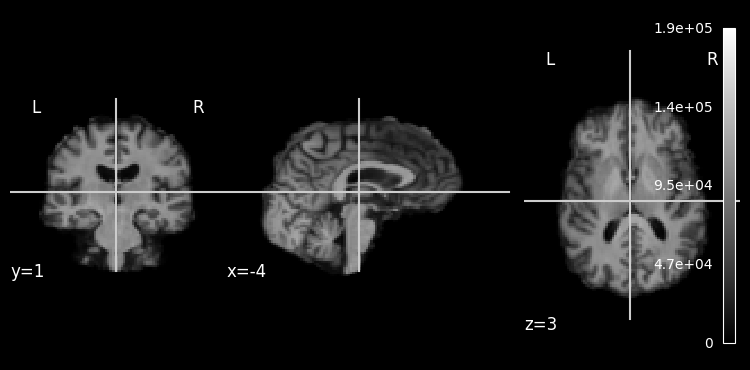

In [ ]:
best_params, best_score = calculate_weight(param_grid, betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, trial_len)

L_task, L_var, L_smooth, selected_BOLD_data = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, None, trial_len)
weights = optimize_voxel_weights(L_task, L_var, L_smooth, alpha_var=best_params[0], alpha_smooth=best_params[1])
weight_img, masked_weights, y = select_opt_weight(selected_BOLD_data, weights, active_low_var_voxels.astype(bool), affine)
print(y.shape)

np.save(f"best_params_session{ses}_run{run}.npy", best_params)
np.save(f"masked_weights_session{ses}_run{run}.npy", masked_weights)
np.save(f"all_weights_session{ses}_run{run}.nii", weight_img)
np.save(f"reconstructed_sig_session{ses}_run{run}.npy",y)


save_path = f"opt_5_percent_weight_on_brain__sub{sub}_session{ses}_run{run}.png"
plot_on_brain(anat_img, weight_img, save_path)

/tmp/ipykernel_68120/1138115005.py:7: RuntimeWarning: invalid value encountered in cast
  selected_voxels_img = new_img_like(anat_img, active_low_var_voxels_reor.astype(np.uint8))
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


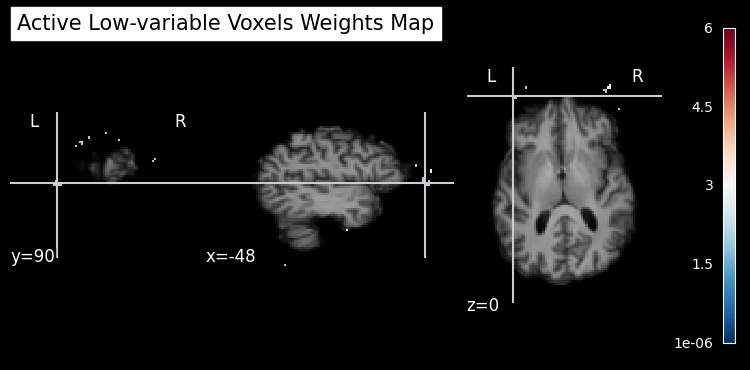

In [52]:
selected_voxels = nib.Nifti1Image(active_low_var_voxels.astype(np.uint8), affine)
ornt_func = nib.orientations.io_orientation(selected_voxels.affine)
xform = nib.orientations.ornt_transform(ornt_func, ornt_anat)

weights = np.load(f'/home/zkavian/thesis_code_git/Optim_fMRI/masked_weights_session1_run1.npy')
active_low_var_voxels_reor = nib.orientations.apply_orientation(weights*10000, xform)
selected_voxels_img = new_img_like(anat_img, active_low_var_voxels_reor.astype(np.uint8))
plot_stat_map(selected_voxels_img, bg_img=anat_img, display_mode='ortho',
              resampling_interpolation='nearest', title='Active Low-variable Voxels Weights Map')
view = view_img(selected_voxels_img, bg_img=anat_img, cmap='jet')  # shows sliders to move cuts
view.save_as_html(f"low_var_active_brain_weights_view_session{ses}_run1.html")

In [50]:
active_low_var_voxels_reor[~np.isnan(active_low_var_voxels_reor)]

array([0.2726221 , 0.27865863, 0.27673677, 0.27292815, 0.27643695,
       0.33153665, 0.2737176 , 0.32213765, 0.2785185 , 0.2816798 ,
       0.2820836 , 0.2825488 , 0.27729484, 0.6410985 , 0.35865057,
       0.27202192, 0.27673823, 0.27937537, 0.27977663, 0.28071752,
       0.2852148 , 0.31624663, 0.27506697, 0.3770683 , 0.27297896,
       0.28275537, 0.27680326, 0.27551767, 0.27431166, 0.27905002,
       0.27775237, 0.27653834, 0.27712184, 0.2775591 , 0.31005096,
       0.2737532 , 0.27528378, 0.2749081 , 0.27599412, 0.27838597,
       0.27667412, 0.2873288 , 0.27730584, 0.29124057, 0.27308723,
       0.27225852, 0.2778404 , 0.27570263, 0.27539665, 0.30162296,
       0.28741708, 0.27285147, 0.27215564, 0.27496886, 0.28491375,
       0.27267697, 0.2767175 , 0.27957782, 0.27662167, 0.27955583,
       0.3013675 , 0.28925428, 0.2753754 , 0.34203252, 0.28346762,
       0.2782527 , 0.2973867 , 0.27838796, 0.28099617, 0.2786902 ,
       0.27444258, 0.27645233, 0.27800512, 0.28378418, 0.28526

In [38]:
np.nansum(weights)

np.float32(0.13999821)

In [ ]:
y = np.load('/home/zkavian/thesis_code_git/reconstructed_sig_session1_run1.npy')

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(y[:270], label='0-100 s')
axs[0].set_xlabel('Time')
axs[0].legend()
axs[1].plot(y[270:540], color = 'orange', label='100-200 s')
axs[1].set_xlabel('Time')
axs[1].legend()

fig.suptitle("Reconstructed Signal")
plt.tight_layout()
plt.show()

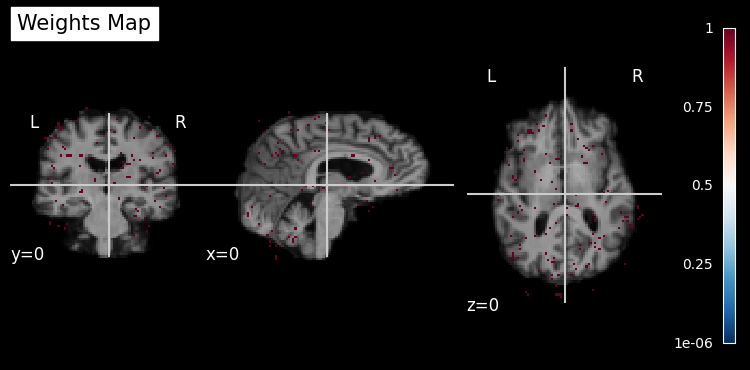

In [102]:
active_low_var_voxels_reor = nib.orientations.apply_orientation(active_low_var_voxels, xform)
selected_voxels_img = new_img_like(anat_img, active_low_var_voxels_reor.astype(np.uint8))
plot_stat_map(selected_voxels_img, bg_img=anat_img, display_mode='ortho',
              resampling_interpolation='nearest', title='Weights Map', cut_coords=(0,0,0))

/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_11086/2284822873.py:2: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  view = view_img(selected_voxels_img, bg_img=anat_img)  # shows sliders to move cuts



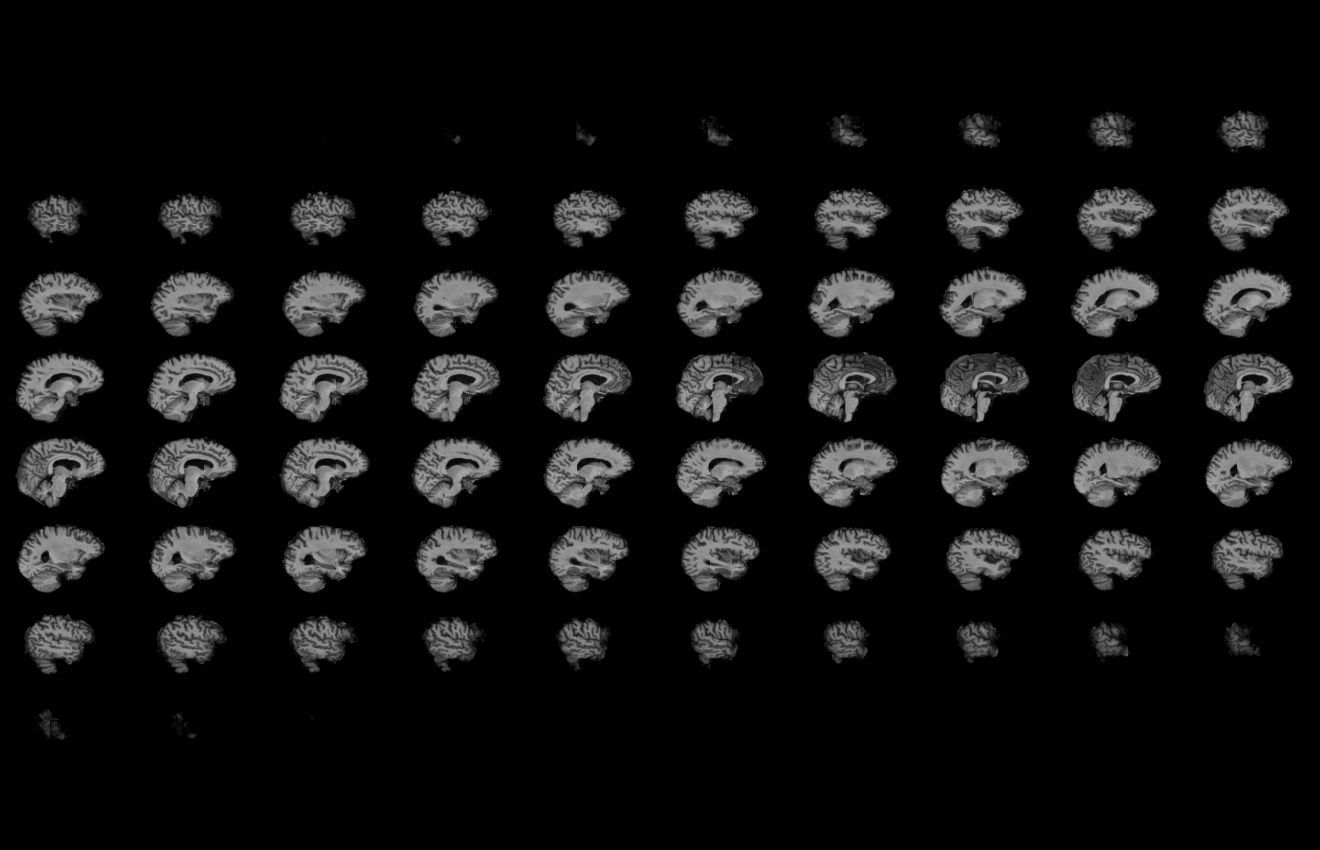
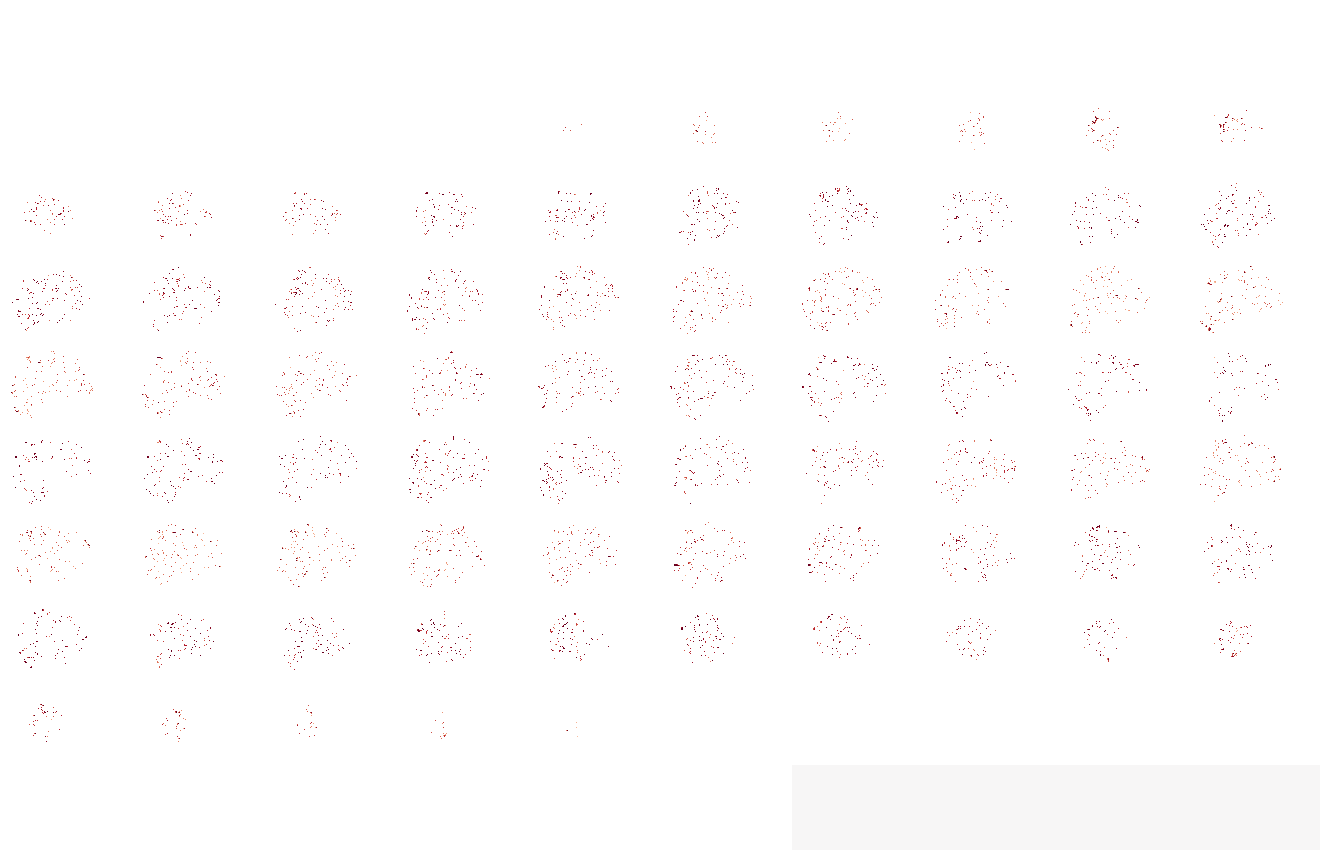

In [103]:
from nilearn.plotting import view_img
view = view_img(selected_voxels_img, bg_img=anat_img)  # shows sliders to move cuts
view  # in a notebook this renders an interactive widget


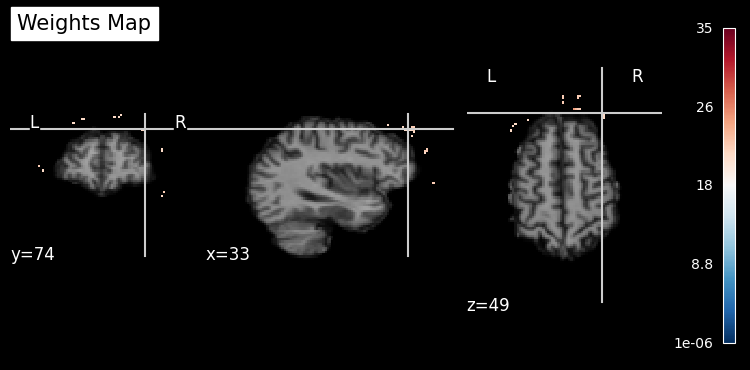

In [88]:
weights = np.load('/home/zkavian/thesis_code_git/masked_weights_session1_run1.npy')
weights_clean = np.nan_to_num(weights, nan=0.0)*100000
active_low_var_voxels_reor = nib.orientations.apply_orientation(weights_clean, xform)
selected_voxels_img = new_img_like(anat_img, active_low_var_voxels_reor.astype(np.uint8))
plot_stat_map(selected_voxels_img, bg_img=anat_img, display_mode='ortho',
              resampling_interpolation='nearest', title='Weights Map')


In [84]:
weights_clean.mean()

np.float32(1.4297203e-07)

In [89]:
# best_params, best_score = calculate_weight(param_grid, betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, trial_len)

L_task, L_var, L_smooth, selected_BOLD_data = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, None, trial_len)
# weights = optimize_voxel_weights(L_task, L_var, L_smooth, alpha_var=best_params[0], alpha_smooth=best_params[1])
# weight_img, masked_weights, y = select_opt_weight(selected_BOLD_data, weights, active_low_var_voxels.astype(bool), affine)

(6266, 90, 9)
(6266, 90, 9)


In [91]:
L_task.min()

np.float32(0.05082892)

In [92]:
L_var.min()

np.float64(-11534.147416245349)

In [93]:
L_smooth.min()

np.float64(-0.9996931105686206)

In [99]:
selected_BOLD_data.max()

np.float64(16088.4951171875)

In [95]:
bold = nib.load(BOLD_path_org).get_fdata()

In [100]:
bold.max()

np.float64(17815.96875)